<a href="https://colab.research.google.com/github/rogeriothur/case-ifood/blob/main/analise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas

In [167]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss

from imblearn.over_sampling import SMOTE

## Métodos para ajudar no desenvolvimento da solução

In [168]:
def g_contagem(dataframe, coluna, xlabel, ylabel):
    plt.figure(figsize=(15,10))

    sns.countplot(x=coluna, data=dataframe)

    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel(ylabel,fontsize=15)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)

    return plt.show()

In [169]:
def g_histograma(coluna, titulo):
    plt.figure(figsize=(15,10))

    sns.distplot(coluna, color='r', kde=False)

    plt.title(titulo, fontsize=18)

    return plt.show()

In [170]:
def g_boxplot(dataframe, coluna):
    plt.figure(figsize=(15, 10))
    plt.xlabel('',fontsize=18)

    sns.boxplot(x=coluna, data=dataframe, palette='rocket')

    return plt.show()

In [171]:
def g_scatter_segmento(df, x, y):
    plt.figure(figsize=(15,10))

    sns.scatterplot(x=x, y=y, data=df, hue='fidelidade', size='fidelidade', sizes=(50,150), size_order=['black', 'platinum', 'gold', 'silver'])

    plt.show()

In [172]:
def amplitude_interquartil(df, coluna):
    
    q1 = coluna.quantile(.25)
    q3 = coluna.quantile(.75)
    iiq = q3 - q1
    
    limite_inferior = q1 - (1.5 * iiq)
    limite_superior = q3 + (1.5 * iiq)
    
    filtro = (coluna >= limite_inferior) & (coluna <= limite_superior)
    return df[filtro]

In [173]:
def eda(df):
    """
    Gera uma dataframe com informações relevantes sobre o mesmo.
    Generates a dataframe with relevant information about it
    
    :param df: pd.DataFrame para ser realizada a exploração
    :param df: pd.DataFrameto be explored
    """
    
    explorar = pd.DataFrame({
        'tipo' : df.dtypes,
        'quantidade_nula' : df.isnull().sum()
    })
    
    explorar['porcentagem_nula'] = np.round((explorar.quantidade_nula / df.shape[0]) * 100, 4)
    
    display(f'Entradas: {df.shape[0]}')
    display(f'Variáveis: {df.shape[1]}')
    
    return explorar.sort_values(by='quantidade_nula', ascending=False)

In [174]:
# Criando pontuação com base nos próprios quartis para criar segmentos de clientes
def determinar_subdivisao(df, coluna, is_recencia, coluna_nova):
    if is_recencia == True:

        quartis = df[coluna].quantile(q=[0.25, 0.50, 0.75])
        df[coluna_nova] = 0

        for indice, valor in df[coluna].items():
            if valor <= int(quartis.values[0]):
                df.loc[indice, coluna_nova] = 1
            elif valor <= int(quartis.values[1]):
                df.loc[indice, coluna_nova] = 2
            elif valor <= int(quartis.values[2]):
                df.loc[indice, coluna_nova] = 3
            else:
                df.loc[indice, coluna_nova] = 4
        
    else:
        quartis = df[coluna].quantile(q=[.25, .5, .75])
        df[coluna_nova] = 0

        for indice, valor in df[coluna].items():
            if valor <= quartis.values[0]:
                df.loc[indice, coluna_nova] = 4
            elif valor <= quartis.values[1]:
                df.loc[indice, coluna_nova] = 3
            elif valor <= quartis.values[2]:
                df.loc[indice, coluna_nova] = 2
            else:
                df.loc[indice, coluna_nova] = 1

    
    return df

## Carregando dados

In [175]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/ifood/ifood-data-business-analyst-test/master/ml_project1_data.csv', sep=',')

In [176]:
df_raw.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,"58,138.00",0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,"46,344.00",1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,"71,613.00",0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,"26,646.00",1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,"58,293.00",1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


**Dicionário das variáveis**

* `ID` - número de id gerado para identificar o cliente
* `Year_Birth` - ano de nascimento
* `Education` - grau de educação do cliente:
    - Graduation
    - PhD
    - Master
    - 2n Cycle
    - Basic
* `Marital_Status` - estado civil do cliente
* `Income` - renda familiar anual do cliente
* `Kidhome` - número de crianças pequenas na casa do cliente 
* `Teenhome` - número de filhos adolescentes na casa do cliente
* `Dt_Customer` - data de inscrição do cliente na empresa
* `Recency` - número de dias desde a última compra
* `MntWines` - valor gasto em vinhos nos últimos 2 anos
* `MntFruits` - valor gasto em vinhos nos últimos 2 anos
* `MntMeatProducts` - valor gasto em carnes nos últimos 2 anos
* `MntFishProducts` - valor gasto em peixes nos últimos 2 anos
* `MntSweetProducts` - valor gasto em doces nos últimos 2 anos
* `MntGoldProds` - valor gasto em produtos 'gold' nos últimos 2 anos
* `NumDealsPurchases` - número de compras feitas com desconto
* `NumWebPurchases` - número de compras feitas através do site da empresa
* `NumCatalogPurchases` - número de compras feitas usando o catálogo
* `NumStorePurchases` - número de compras feitas diretamente nas lojas
* `NumWebVisitsMonth` - número de visitas no site da empresa no último mês
* `AcceptedCmp1` - 1 se o cliente aceitou a oferta na 1ª campanha, 0 caso contrário
* `AcceptedCmp2` - 1 se o cliente aceitou a oferta na 2ª campanha, 0 caso contrário
* `AcceptedCmp3` - 1 se o cliente aceitou a oferta na 3ª campanha, 0 caso contrário
* `AcceptedCmp4` - 1 se o cliente aceitou a oferta na 4ª campanha, 0 caso contrário
* `AcceptedCmp5` - 1 se o cliente aceitou a oferta na 5ª campanha, 0 caso contrário
* `Complain` - 1 se o cliente reclamou nos últimos 2 anos, 0 caso contrário
* `Z_CostContact` - custo de contato*
* `Z_Revenue` - receita*
* `Response` - 1 se o cliente aceitou a oferta na última campanha, 0 caso contrário

# Descrição dos dados

## Renomenando colunas

In [177]:
df = df_raw.copy()

In [178]:
df.rename(columns={
    'ID': 'id',
    'Year_Birth': 'ano_nascimento',
    'Education': 'grau_educacao',
    'Marital_Status': 'estado_civil',
    'Income': 'renda_anual',
    'Kidhome': 'num_criancas',
    'Teenhome': 'num_adolescentes',
    'Dt_Customer': 'data_inscricao',
    'Recency': 'recencia',
    'MntWines': 'valor_vinhos',
    'MntFruits': 'valor_frutas',
    'MntMeatProducts': 'valor_carnes',
    'MntFishProducts': 'valor_peixes',
    'MntSweetProducts': 'valor_doces',
    'MntGoldProds': 'valor_gold',
    'NumDealsPurchases': 'num_compras_promo',
    'NumWebPurchases': 'num_compras_web',
    'NumCatalogPurchases': 'num_compras_catalogo',
    'NumStorePurchases': 'num_compras_loja',
    'NumWebVisitsMonth': 'num_visitas_web',
    'AcceptedCmp3': 'campanha_3',
    'AcceptedCmp4': 'campanha_4',
    'AcceptedCmp5': 'campanha_5',
    'AcceptedCmp1': 'campanha_1',
    'AcceptedCmp2': 'campanha_2',
    'Complain': 'reclamou',
    'Z_CostContact': 'custo_contato',
    'Z_Revenue': 'receita_contato',
    'Response': 'resposta'
}, inplace=True)

Custo do contato = 3 * numero de clientes contatados (2240)
receita = 11 * numero de clientes que aceitaram (resposta)

## Conhecendo mais sobre a base de dados
- tipos, dimensões, valores ausentes

In [179]:
eda(df)

'Entradas: 2240'

'Variáveis: 29'

,tipo,quantidade_nula,porcentagem_nula
renda_anual,float64,24,1.07
id,int64,0,0.00
num_compras_promo,int64,0,0.00
receita_contato,int64,0,0.00
custo_contato,int64,0,0.00
reclamou,int64,0,0.00
campanha_2,int64,0,0.00
campanha_1,int64,0,0.00
campanha_5,int64,0,0.00
campanha_4,int64,0,0.00


## Alterando tipos de dados

In [180]:
df.data_inscricao = pd.to_datetime(df.data_inscricao)
df.dtypes

id                               int64
ano_nascimento                   int64
grau_educacao                   object
estado_civil                    object
renda_anual                    float64
num_criancas                     int64
num_adolescentes                 int64
data_inscricao          datetime64[ns]
recencia                         int64
valor_vinhos                     int64
valor_frutas                     int64
valor_carnes                     int64
valor_peixes                     int64
valor_doces                      int64
valor_gold                       int64
num_compras_promo                int64
num_compras_web                  int64
num_compras_catalogo             int64
num_compras_loja                 int64
num_visitas_web                  int64
campanha_3                       int64
campanha_4                       int64
campanha_5                       int64
campanha_1                       int64
campanha_2                       int64
reclamou                 

## Excluindo valores ausentes e verificando dados duplicados
- Por se tratar de apenas 1% do base

In [181]:
df.dropna(inplace=True)

In [182]:
# Nenhum registro duplicado
df.duplicated().sum()

0

## Descrição estatística

Histograma de cada variável para ter uma noção da distribuição dos valores em cada variável

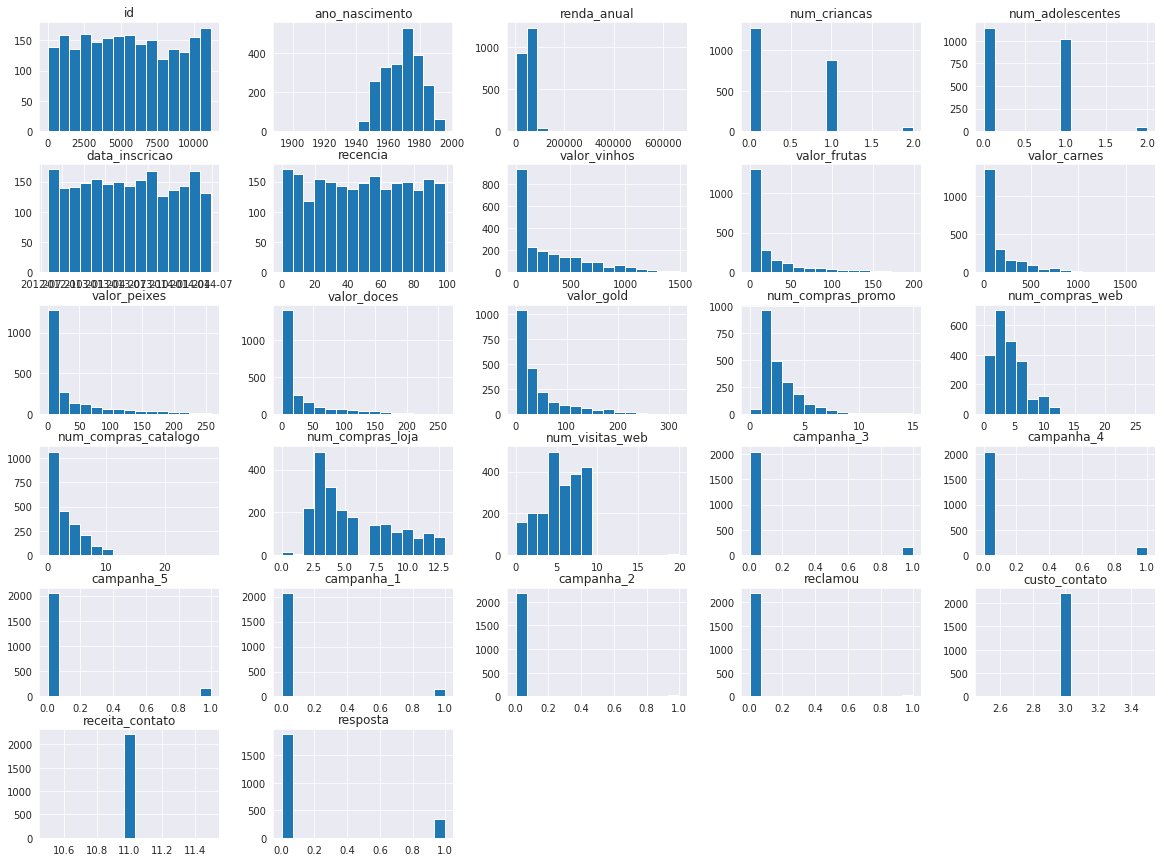

In [183]:
df.hist(bins=15, figsize=(20,15))
plt.show()

In [184]:
df.select_dtypes(include=['int64', 'float64']).describe().T 

,count,mean,std,min,25%,50%,75%,max
id,"2,216.00","5,588.35","3,249.38",0.00,"2,814.75","5,458.50","8,421.75","11,191.00"
ano_nascimento,"2,216.00","1,968.82",11.99,"1,893.00","1,959.00","1,970.00","1,977.00","1,996.00"
renda_anual,"2,216.00","52,247.25","25,173.08","1,730.00","35,303.00","51,381.50","68,522.00","666,666.00"
num_criancas,"2,216.00",0.44,0.54,0.00,0.00,0.00,1.00,2.00
num_adolescentes,"2,216.00",0.51,0.54,0.00,0.00,0.00,1.00,2.00
recencia,"2,216.00",49.01,28.95,0.00,24.00,49.00,74.00,99.00
valor_vinhos,"2,216.00",305.09,337.33,0.00,24.00,174.50,505.00,"1,493.00"
valor_frutas,"2,216.00",26.36,39.79,0.00,2.00,8.00,33.00,199.00
valor_carnes,"2,216.00",167.00,224.28,0.00,16.00,68.00,232.25,"1,725.00"
valor_peixes,"2,216.00",37.64,54.75,0.00,3.00,12.00,50.00,259.00


Com os gráficos e com o uso do método *describe*, podemos tirar algumas conclusões:
- **Ano de nascimento**: Até que tem uma "normal", porém provavelmente tem alguns outlieres, o ano mínino é 1893. Temos que verificar isso!
<br><br>
- **Renda anual**: Tem um range muito grande
    - renda miníma: 1,7k
    - renda máxima: 666K
    - pelo gráfico podemos afirmar que a Curtose é bastante positiva, pois tem um grande pico em torno dos 50k
<br><br>
- **Em relação ao número de crianças e adolescentes**:
    - podemos afirmar que 75% dos clientes tem 0 crianças ou adolescentes
<br><br>    
- **Recência**: Está entre 0 dias até 99 dias (um pouco mais de 3 meses)
    - pode ser que temos clientes que fazem compras por semana, mensal e trimestral
<br><br>
- **Produtos**: Tanto as Carnes quanto os Vinhos são mais vendidos do que os outros produtos
<br><br>
- **Compras**:
    - Na média as compras dos clientes estão sendo nas lojas e pela web, porém compras no catálogo tem um maior número máximo.
<br><br>
- **Número de visitas ao site**: Importante salientar que tem cliente que não visitou o site.

# Análise em algumas variáveis

In [185]:
df1 = df.copy()

## Ano de nascimento

In [186]:
df1.ano_nascimento.describe()

count   2,216.00
mean    1,968.82
std        11.99
min     1,893.00
25%     1,959.00
50%     1,970.00
75%     1,977.00
max     1,996.00
Name: ano_nascimento, dtype: float64

In [187]:
df1.ano_nascimento.unique()

array([1957, 1954, 1965, 1984, 1981, 1967, 1971, 1985, 1974, 1950, 1976,
       1959, 1952, 1987, 1946, 1980, 1949, 1982, 1979, 1951, 1969, 1989,
       1963, 1970, 1973, 1943, 1975, 1996, 1968, 1964, 1977, 1978, 1955,
       1966, 1988, 1948, 1958, 1972, 1960, 1983, 1945, 1991, 1962, 1953,
       1956, 1992, 1961, 1900, 1986, 1893, 1990, 1947, 1899, 1993, 1994,
       1941, 1944, 1995, 1940])

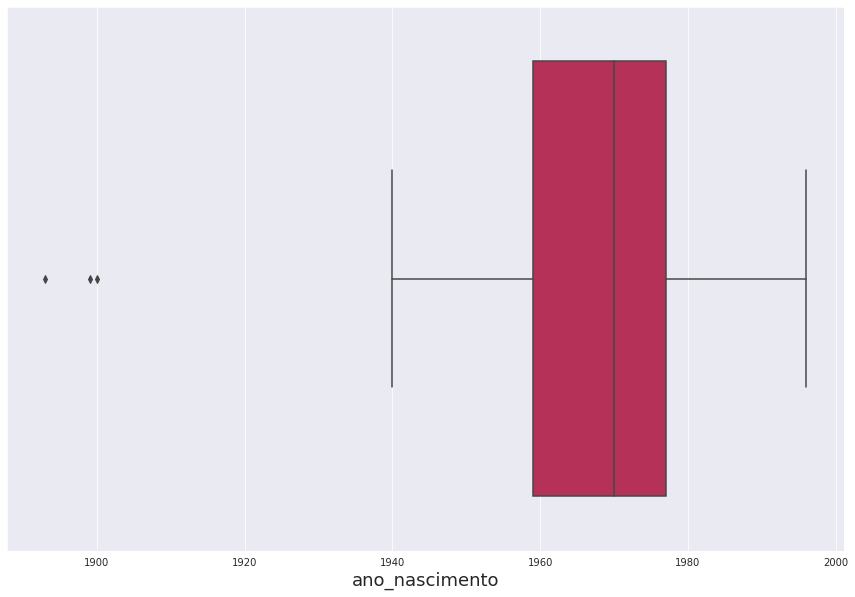

In [188]:
g_boxplot(df1, 'ano_nascimento')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


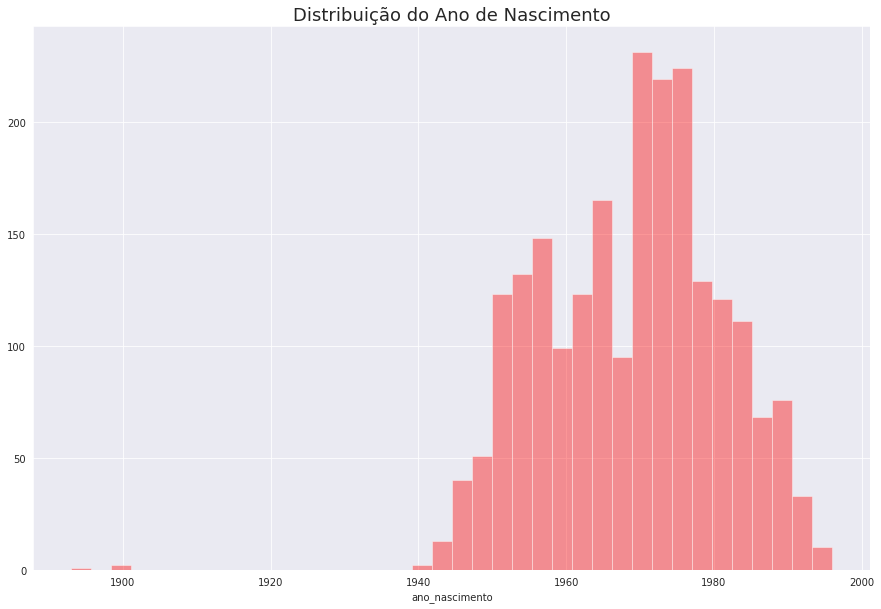

In [189]:
g_histograma(df1.ano_nascimento, 'Distribuição do Ano de Nascimento')

In [190]:
# Remover outliers usando amplitude interquartil
df1 = amplitude_interquartil(df1, df1.ano_nascimento.sort_values())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


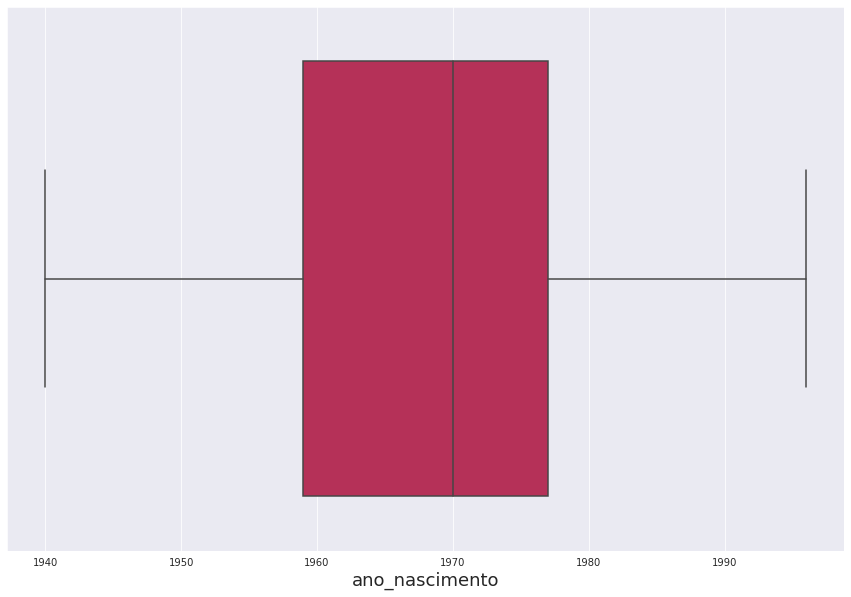

In [191]:
g_boxplot(df1, 'ano_nascimento')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


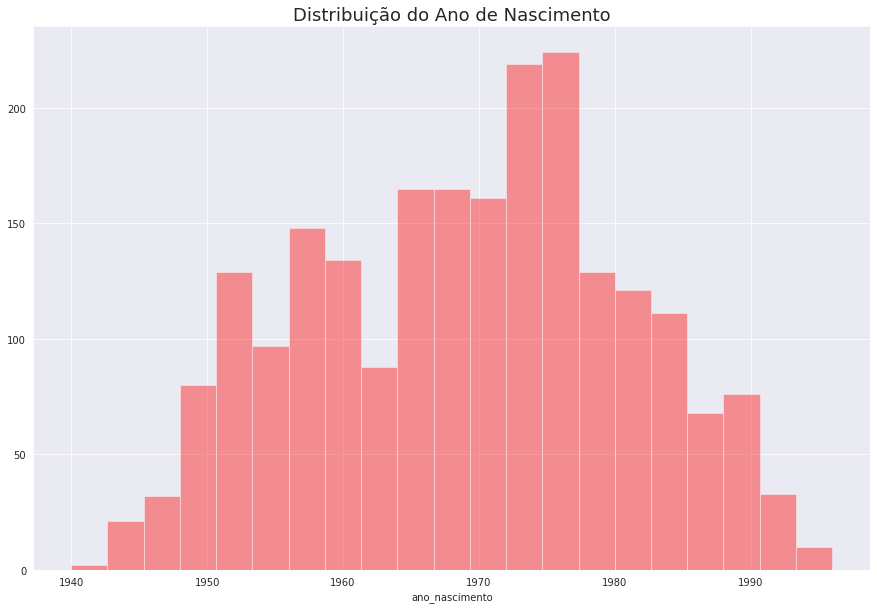

In [192]:
g_histograma(df1.ano_nascimento, 'Distribuição do Ano de Nascimento')

## Grau de educação

In [193]:
df1.grau_educacao.unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [194]:
df1.grau_educacao.replace({
    '2n Cycle': 'Master'
}, inplace=True)

In [195]:
# Porcentagem dos clientes por grau de educacao
df1.grau_educacao.value_counts(normalize=True) * 100

Graduation   50.43
Master       25.44
PhD          21.69
Basic         2.44
Name: grau_educacao, dtype: float64

In [196]:
df1.grau_educacao.value_counts()

Graduation    1116
Master         563
PhD            480
Basic           54
Name: grau_educacao, dtype: int64

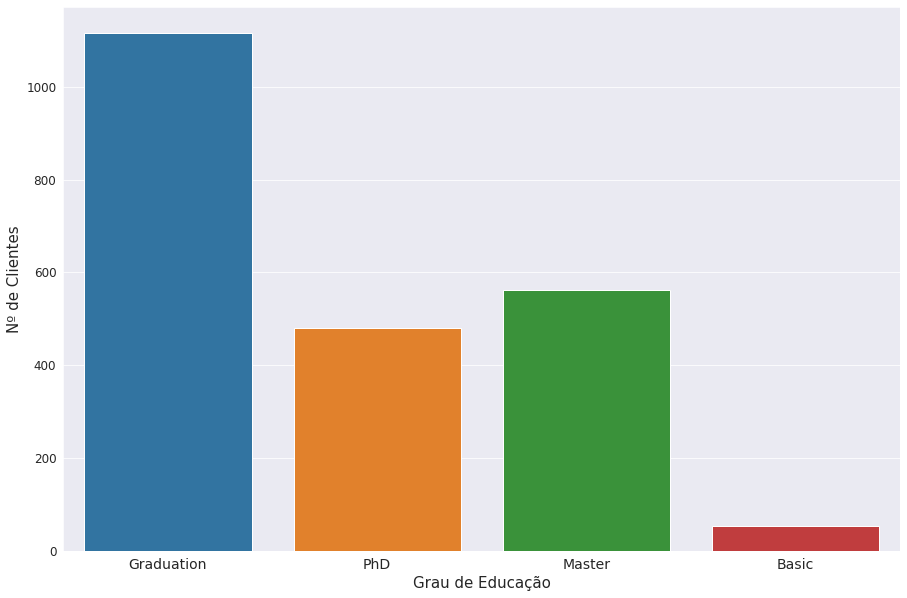

In [197]:
g_contagem(df1, 'grau_educacao', 'Grau de Educação', 'Nº de Clientes')

In [198]:
# Porcentagem dos clientes que aceitaram a oferta da 6ª campanha por grau de educação
#df1.groupby(['grau_educacao', 'resposta']).agg({'campanha_1': 'count'})[['campanha_1']].apply(lambda x: 100*x/x.sum()).T

## Estado civil

In [199]:
df1.estado_civil.unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [200]:
df1.estado_civil.value_counts(normalize = True) * 100

Married    38.73
Together   25.85
Single     21.24
Divorced   10.44
Widow       3.43
Alone       0.14
Absurd      0.09
YOLO        0.09
Name: estado_civil, dtype: float64

In [201]:
df1.estado_civil.value_counts()

Married     857
Together    572
Single      470
Divorced    231
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: estado_civil, dtype: int64

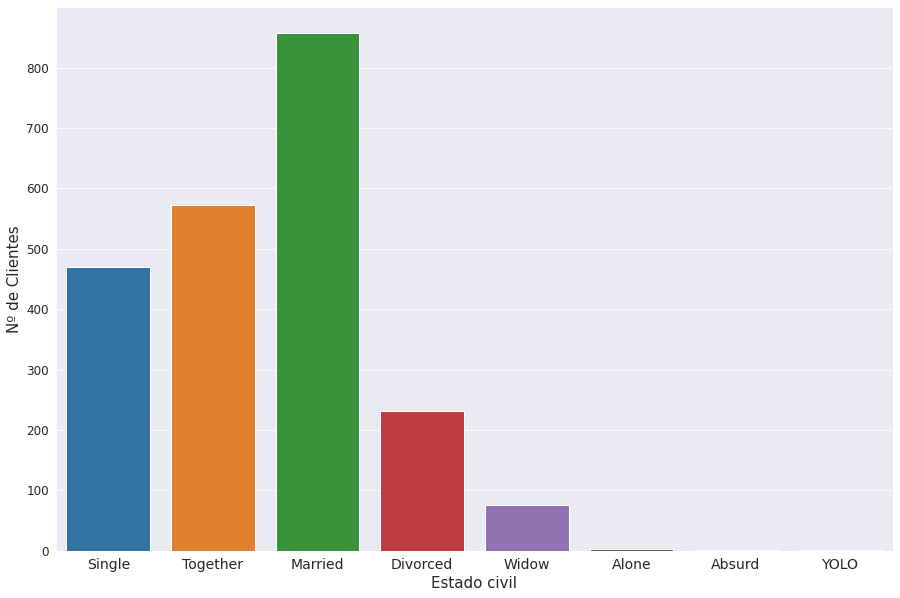

In [202]:
g_contagem(df1, 'estado_civil', 'Estado civil', 'Nº de Clientes')

In [203]:
# Excluir estado civil que não faz sentido para análise além de representar muito pouco na base de dados
df1.drop(df1[(df1.estado_civil == 'Absurd') | (df1.estado_civil == 'YOLO') ].index, inplace = True)

In [204]:
# Definir o estado civil mais próximo da "lei"
df1.estado_civil.replace({
    'Alone': 'Single',
    'Together': 'Married'
}, inplace=True)

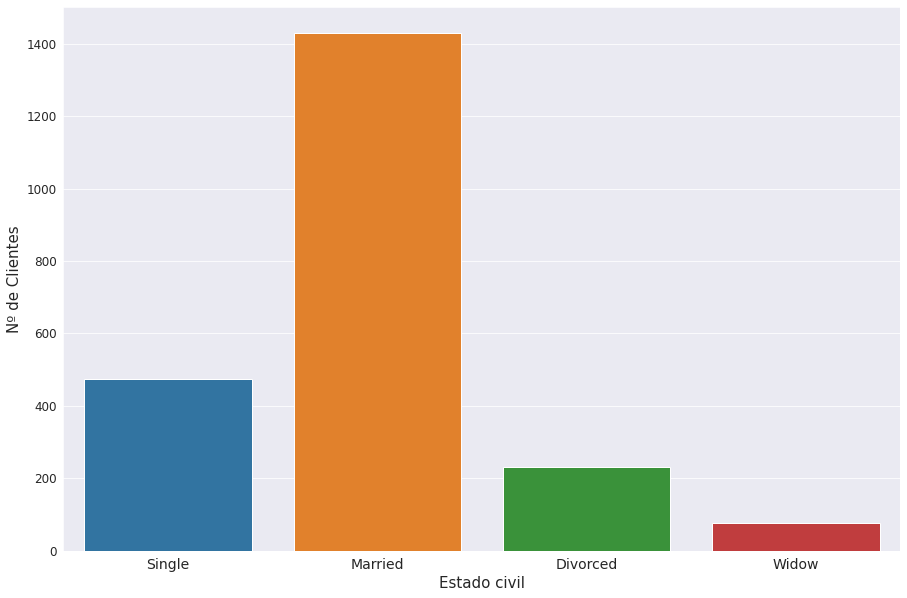

In [205]:
g_contagem(df1, 'estado_civil', 'Estado civil', 'Nº de Clientes')

In [206]:
df1.columns

Index(['id', 'ano_nascimento', 'grau_educacao', 'estado_civil', 'renda_anual',
       'num_criancas', 'num_adolescentes', 'data_inscricao', 'recencia',
       'valor_vinhos', 'valor_frutas', 'valor_carnes', 'valor_peixes',
       'valor_doces', 'valor_gold', 'num_compras_promo', 'num_compras_web',
       'num_compras_catalogo', 'num_compras_loja', 'num_visitas_web',
       'campanha_3', 'campanha_4', 'campanha_5', 'campanha_1', 'campanha_2',
       'reclamou', 'custo_contato', 'receita_contato', 'resposta'],
      dtype='object')

## Renda

In [207]:
df1.renda_anual.describe()

count     2,209.00
mean     52,221.80
std      25,193.00
min       1,730.00
25%      35,196.00
50%      51,373.00
75%      68,487.00
max     666,666.00
Name: renda_anual, dtype: float64

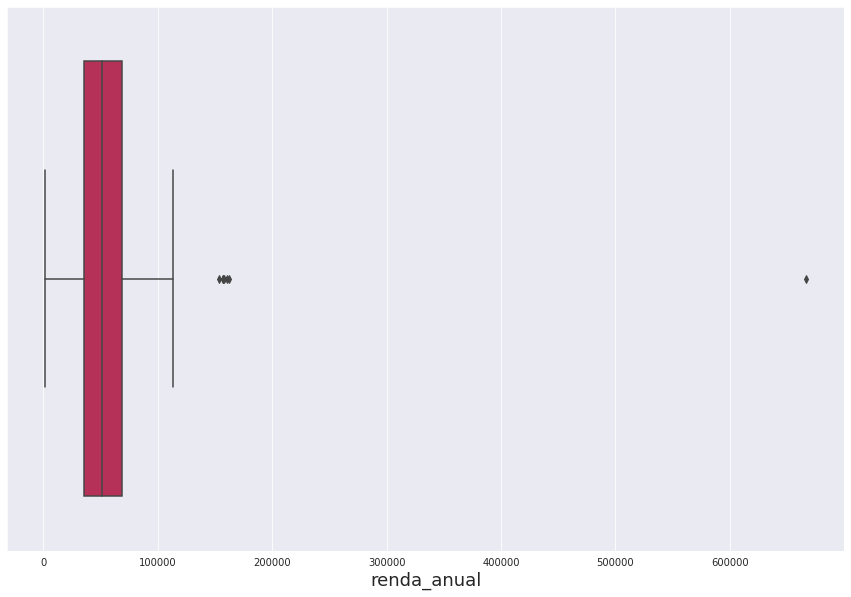

In [208]:
g_boxplot(df1, 'renda_anual')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


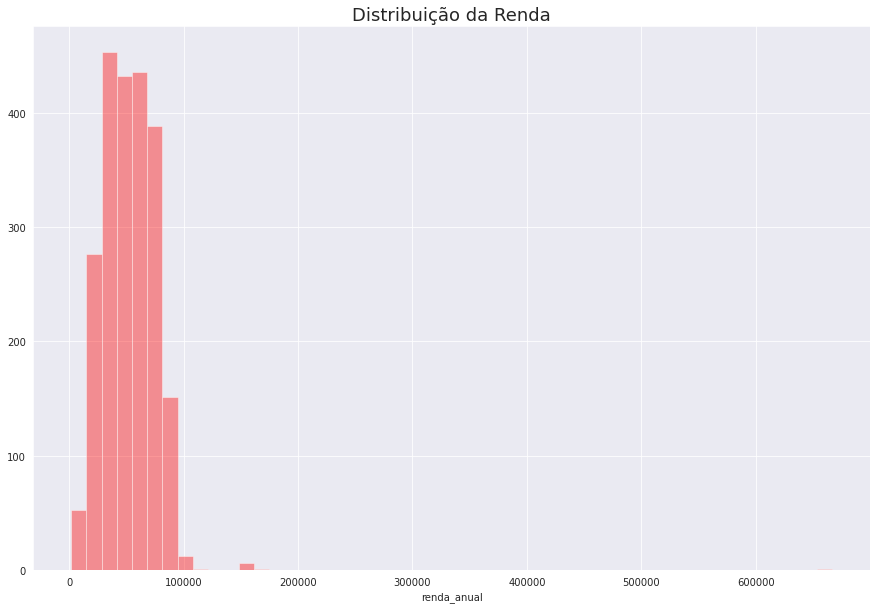

In [209]:
g_histograma(df1.renda_anual, 'Distribuição da Renda')

In [210]:
# Remover outliers usando amplitude interquartil
df1 = amplitude_interquartil(df1, df1.renda_anual.sort_values())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


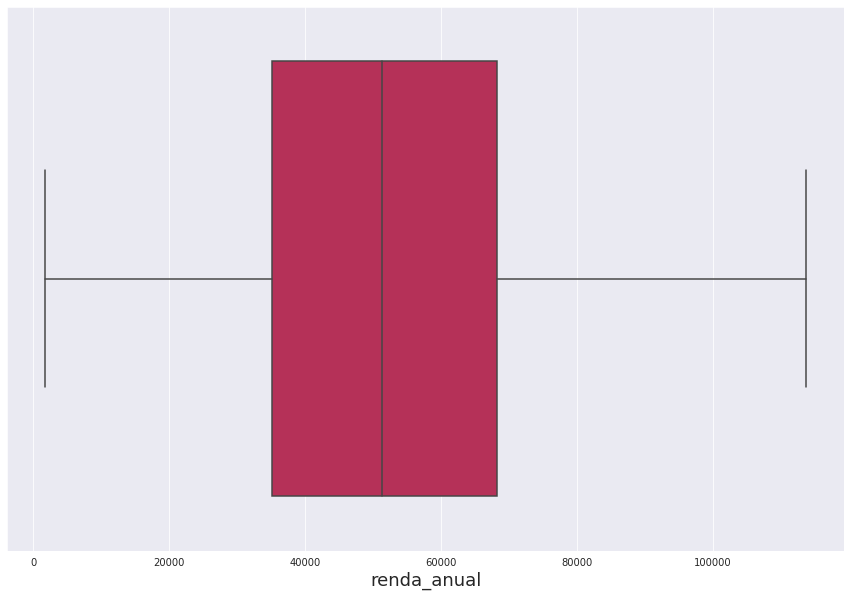

In [211]:
g_boxplot(df1, 'renda_anual')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


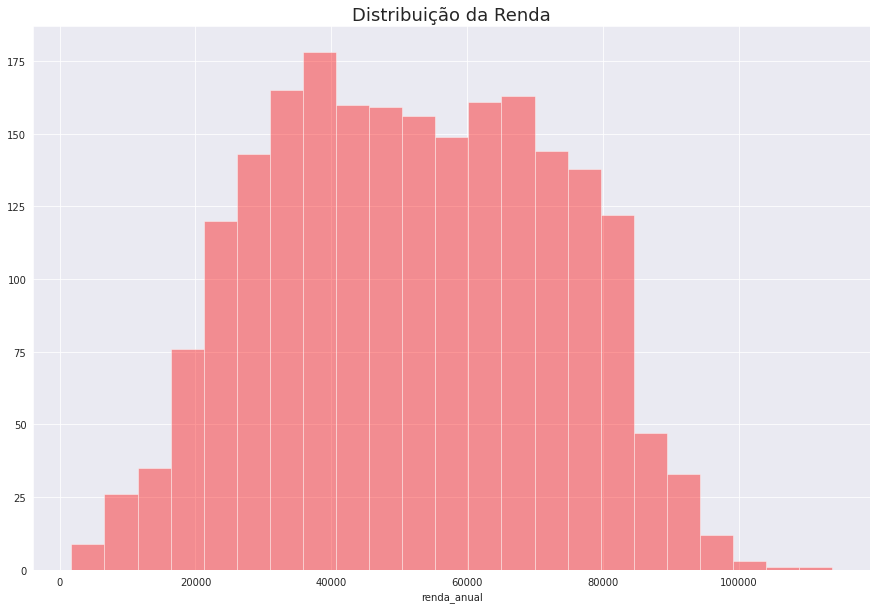

In [212]:
g_histograma(df1.renda_anual, 'Distribuição da Renda')

In [213]:
df1.renda_anual.describe()

count     2,201.00
mean     51,606.14
std      20,721.18
min       1,730.00
25%      35,178.00
50%      51,287.00
75%      68,281.00
max     113,734.00
Name: renda_anual, dtype: float64

# Feature Engineering

In [214]:
df2 = df1.copy()

## Idade
- Criar variável idade
- A idade foi criada baseada na data de inscrição do cliente na base de dados;

Criei esta variável desta forma pois acredito que é pertinente a situação neste período de tempo

In [215]:
df2['idade'] = df2.data_inscricao.dt.year - df2.ano_nascimento

In [216]:
df2.sample(5)

,id,ano_nascimento,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,data_inscricao,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade
163,10095,1975,PhD,Divorced,"74,165.00",0,0,2013-05-01,9,1001,12,240,16,12,12,1,5,4,10,2,0,0,0,0,0,0,3,11,0,38
189,6431,1964,PhD,Married,"45,759.00",1,1,2013-02-23,13,42,1,18,3,0,4,2,2,0,3,7,0,0,0,0,0,0,3,11,0,49
723,10936,1965,Graduation,Married,"72,190.00",0,0,2013-02-13,79,597,166,597,172,166,249,1,5,6,4,3,0,0,0,0,0,0,3,11,0,48
57,7437,1988,Graduation,Single,"27,938.00",1,0,2014-04-28,31,13,0,8,2,1,5,1,1,0,4,3,0,0,0,0,0,0,3,11,0,26
1837,332,1957,Graduation,Married,"47,743.00",0,1,2013-03-22,56,198,2,43,0,12,20,3,4,1,6,6,0,1,0,0,0,0,3,11,0,56


In [217]:
df2.idade.describe()

count   2,201.00
mean       44.13
std        11.74
min        16.00
25%        36.00
50%        43.00
75%        54.00
max        73.00
Name: idade, dtype: float64

In [218]:
df2 = df2.drop(df2[df2.idade < 18].index)

In [219]:
# Criar categorias baseada na idade dos clientes, pode ser importante para segmentação dos clientes
df2['idade_grupo'] = pd.qcut(df2.idade, q=6, labels=['18-32', '33-38', '39-43', '44-49', '50-57', '58-73'])

In [220]:
df2.sample(5)

,id,ano_nascimento,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,data_inscricao,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade,idade_grupo
1133,2975,1976,Graduation,Married,"85,606.00",0,1,2012-11-12,89,717,42,864,219,30,84,2,6,7,9,3,0,0,0,1,0,0,3,11,0,36,33-38
1779,2681,1984,Master,Married,"65,370.00",0,0,2013-08-01,1,71,22,112,138,89,29,1,2,3,13,1,0,0,0,0,0,0,3,11,0,29,18-32
1732,4351,1955,Graduation,Divorced,"37,244.00",1,1,2013-04-27,90,18,2,10,0,0,25,1,1,1,2,7,1,0,0,0,0,0,3,11,0,58,58-73
1483,5868,1980,Graduation,Married,"19,107.00",1,0,2013-08-22,49,2,4,9,10,5,16,2,1,0,3,7,0,0,0,0,0,0,3,11,0,33,33-38
1441,1183,1949,Master,Married,"36,408.00",1,1,2013-09-21,11,9,1,4,3,2,3,1,1,0,2,6,0,0,0,0,0,0,3,11,0,64,58-73


In [221]:
# excluindo variáveis, pois já temos duas variáveis derivadas e não precisamos mas desta variável
df2.drop(columns=['ano_nascimento', 'data_inscricao'], inplace=True)

## Número de dependentes
- Criar variável num_dependentes, será:
    - o total de número de crianças + o total de nº de adolescentes

In [222]:
df2['num_dependentes'] = df2.num_criancas + df2.num_adolescentes

In [223]:
df2.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade,idade_grupo,num_dependentes
300,5827,Graduation,Divorced,"35,246.00",1,1,53,36,0,12,2,2,10,4,3,1,3,5,0,0,0,0,0,0,3,11,0,56,50-57,2
970,10981,Graduation,Married,"84,219.00",0,0,27,434,137,400,45,137,45,1,3,4,10,1,0,0,0,0,0,0,3,11,0,26,18-32,0
233,9617,Graduation,Single,"15,033.00",0,0,37,0,4,5,6,0,4,1,1,0,3,3,0,0,0,0,0,0,3,11,0,63,58-73,0
435,9347,Master,Married,"50,943.00",0,1,49,31,0,7,2,0,6,1,1,0,3,5,0,0,0,0,0,0,3,11,0,57,50-57,1
1256,9094,Master,Married,"62,972.00",0,1,39,313,15,47,20,0,192,2,7,4,3,6,0,0,0,0,0,0,3,11,1,57,50-57,1


## Classificar cliente baseado na recência

In [224]:
df2.recencia.describe()

count   2,198.00
mean       49.06
std        28.94
min         0.00
25%        24.00
50%        49.00
75%        74.00
max        99.00
Name: recencia, dtype: float64

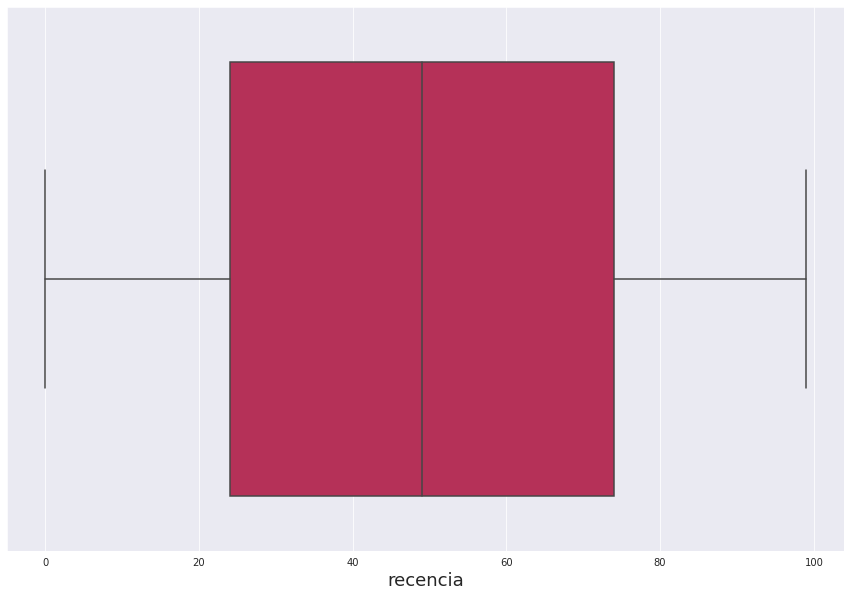

In [225]:
g_boxplot(df2, 'recencia')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


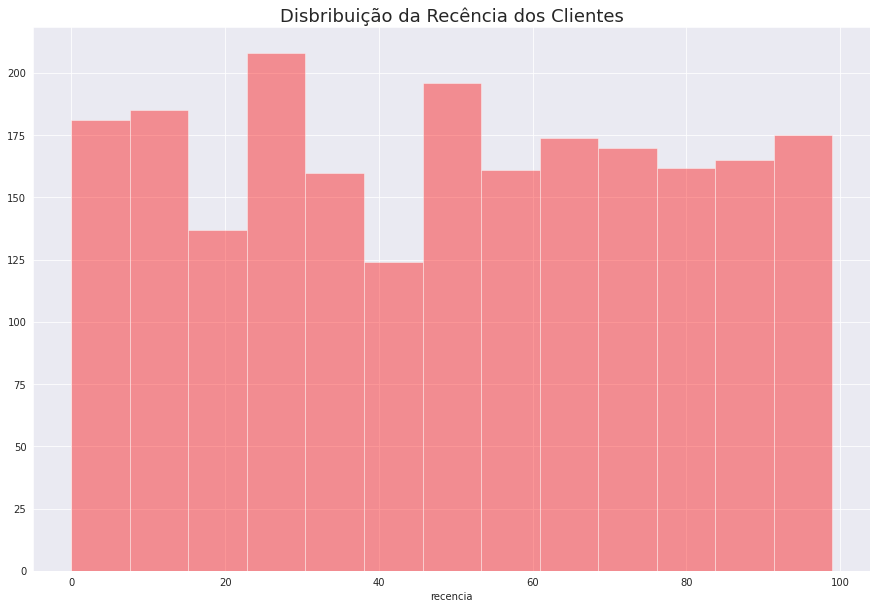

In [226]:
g_histograma(df2.recencia, 'Disbribuição da Recência dos Clientes')

In [227]:
'''
    Muito recente: 0-24
    Recente: 25-49
    Meio recente: 50-74
    Inativo: 75-99
'''

'\n    Muito recente: 0-24\n    Recente: 25-49\n    Meio recente: 50-74\n    Inativo: 75-99\n'

In [228]:
df2['recencia_grupo'] = pd.qcut(df2.recencia, q=4, labels=['Muito recente', 'Recente', 'Meio recente', 'Inativo'])

In [229]:
df2.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade,idade_grupo,num_dependentes,recencia_grupo
298,7119,Graduation,Single,"68,627.00",0,0,45,395,15,263,60,54,38,1,2,3,6,1,0,0,0,0,0,0,3,11,0,31,18-32,0,Recente
1564,10699,Graduation,Married,"44,322.00",1,0,30,46,0,40,3,0,3,2,3,0,3,8,0,0,0,0,0,0,3,11,0,29,18-32,1,Recente
1882,5180,PhD,Divorced,"50,616.00",0,1,56,128,0,16,0,1,4,2,4,0,4,7,0,0,0,0,0,0,3,11,0,46,44-49,1,Meio recente
421,3129,Graduation,Married,"30,096.00",1,0,30,5,3,11,12,5,9,1,2,0,3,6,0,0,0,0,0,0,3,11,0,31,18-32,1,Recente
1281,9516,Master,Divorced,"49,118.00",0,0,90,620,54,239,99,98,119,2,9,7,10,7,0,1,0,0,1,0,3,11,1,41,39-43,0,Inativo


## Total em compras
- Criar a variável total_compras, será:
    - a soma das compras que o cliente fez em cada categoria de produto

In [230]:
df2.columns

Index(['id', 'grau_educacao', 'estado_civil', 'renda_anual', 'num_criancas',
       'num_adolescentes', 'recencia', 'valor_vinhos', 'valor_frutas',
       'valor_carnes', 'valor_peixes', 'valor_doces', 'valor_gold',
       'num_compras_promo', 'num_compras_web', 'num_compras_catalogo',
       'num_compras_loja', 'num_visitas_web', 'campanha_3', 'campanha_4',
       'campanha_5', 'campanha_1', 'campanha_2', 'reclamou', 'custo_contato',
       'receita_contato', 'resposta', 'idade', 'idade_grupo',
       'num_dependentes', 'recencia_grupo'],
      dtype='object')

In [231]:
df2['num_total_compras'] = df2.num_compras_web + df2.num_compras_catalogo + df2.num_compras_loja

In [232]:
df2.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras
805,4599,Master,Married,"49,681.00",0,2,66,411,0,26,0,0,21,6,7,1,7,7,0,0,0,0,0,0,3,11,0,37,33-38,2,Meio recente,15
1486,2939,Master,Married,"79,419.00",0,0,96,751,127,687,20,15,31,1,4,6,4,2,0,0,0,0,0,0,3,11,0,44,44-49,0,Inativo,14
1750,3571,PhD,Married,"63,342.00",0,1,48,918,21,118,13,10,21,3,8,3,5,6,0,1,0,0,0,0,3,11,1,51,50-57,1,Recente,16
98,4646,Master,Married,"78,497.00",0,0,44,207,26,447,75,0,223,1,5,7,12,2,0,0,0,1,0,0,3,11,0,62,58-73,0,Recente,24
2164,7600,Basic,Single,"15,253.00",1,0,13,1,3,3,8,1,13,2,1,0,3,7,0,0,0,0,0,0,3,11,0,21,18-32,1,Muito recente,4


In [233]:
df2.num_total_compras.describe()

count   2,198.00
mean       12.56
std         7.18
min         0.00
25%         6.00
50%        12.00
75%        18.00
max        32.00
Name: num_total_compras, dtype: float64

In [234]:
'''
Muito pouco: 0-6
Pouco: 7-12
Médio: 13-18
Alto: 19-32
'''

'\nMuito pouco: 0-6\nPouco: 7-12\nMédio: 13-18\nAlto: 19-32\n'

In [235]:
df2['num_compras_grupo'] = pd.qcut(df2.num_total_compras, q=4, labels=['Muito pouco', 'Pouco', 'Medio', 'Alto'])

In [236]:
df2.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras,num_compras_grupo
1729,3828,Graduation,Married,"71,107.00",0,1,61,533,10,217,198,174,195,2,7,6,13,4,0,0,0,0,0,0,3,11,0,62,58-73,1,Meio recente,26,Alto
1545,10212,Master,Married,"42,386.00",1,0,43,65,4,16,0,4,11,1,3,0,3,8,0,0,0,0,0,0,3,11,0,27,18-32,1,Recente,6,Muito pouco
1621,9668,Graduation,Married,"18,793.00",1,0,14,4,16,20,0,17,20,3,2,0,4,8,0,0,0,0,0,0,3,11,0,42,39-43,1,Muito recente,6,Muito pouco
864,4120,Master,Single,"49,514.00",1,0,61,88,39,78,58,13,93,2,6,1,4,7,0,0,0,0,0,0,3,11,0,38,33-38,1,Meio recente,11,Pouco
1229,833,Master,Married,"38,452.00",1,1,62,56,0,14,0,0,2,3,3,0,3,7,0,0,0,0,0,0,3,11,0,59,58-73,2,Meio recente,6,Muito pouco


## Valor total gasto
- Criar a variável valor_total, será:
    - a soma dos valores gastos em cada categoria de produtos

In [237]:
df2.columns

Index(['id', 'grau_educacao', 'estado_civil', 'renda_anual', 'num_criancas',
       'num_adolescentes', 'recencia', 'valor_vinhos', 'valor_frutas',
       'valor_carnes', 'valor_peixes', 'valor_doces', 'valor_gold',
       'num_compras_promo', 'num_compras_web', 'num_compras_catalogo',
       'num_compras_loja', 'num_visitas_web', 'campanha_3', 'campanha_4',
       'campanha_5', 'campanha_1', 'campanha_2', 'reclamou', 'custo_contato',
       'receita_contato', 'resposta', 'idade', 'idade_grupo',
       'num_dependentes', 'recencia_grupo', 'num_total_compras',
       'num_compras_grupo'],
      dtype='object')

In [238]:
df2['valor_total'] = df2.valor_vinhos + df2.valor_frutas + df2.valor_carnes + df2.valor_peixes + df2.valor_doces

In [239]:
df2.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras,num_compras_grupo,valor_total
2028,9323,Master,Married,"49,912.00",0,1,5,520,8,223,32,49,42,4,10,5,7,8,1,0,0,0,0,0,3,11,1,63,58-73,1,Muito recente,22,Alto,832
1747,7881,Master,Married,"66,835.00",0,0,21,620,26,195,34,17,141,1,6,4,13,2,0,0,0,0,0,0,3,11,0,67,58-73,0,Muito recente,23,Alto,892
1393,5289,Master,Single,"41,658.00",1,1,30,8,4,12,15,4,29,2,1,1,2,4,0,0,0,0,0,0,3,11,0,37,33-38,2,Recente,4,Muito pouco,43
1907,10680,Graduation,Married,"33,235.00",1,0,71,45,0,16,2,1,6,1,3,0,3,7,0,0,0,0,0,0,3,11,0,28,18-32,1,Meio recente,6,Muito pouco,64
222,4785,PhD,Married,"77,622.00",0,2,3,520,7,154,19,0,14,2,6,3,11,3,0,0,0,0,0,0,3,11,0,44,44-49,2,Muito recente,20,Alto,700


In [240]:
df2.valor_total.describe()

count   2,198.00
mean      562.05
std       576.10
min         4.00
25%        55.25
50%       342.00
75%       962.00
max     2,491.00
Name: valor_total, dtype: float64

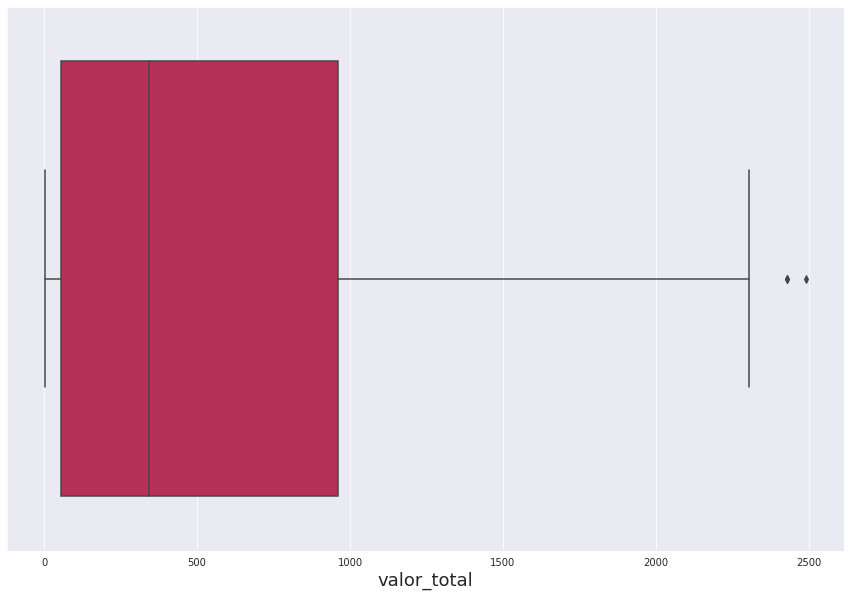

In [241]:
g_boxplot(df2, 'valor_total')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


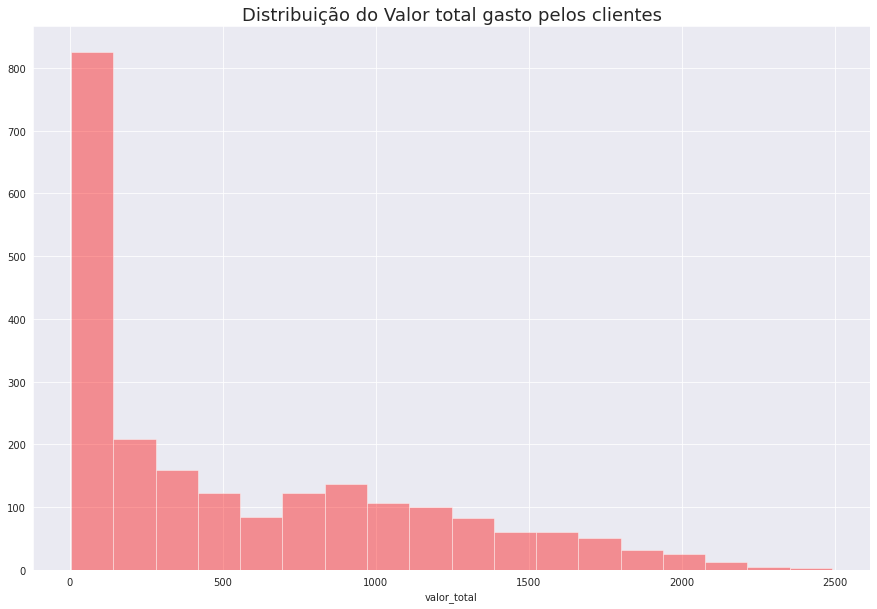

In [242]:
g_histograma(df2.valor_total, 'Distribuição do Valor total gasto pelos clientes')

In [243]:
df2 = amplitude_interquartil(df2, df2.valor_total.sort_values())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


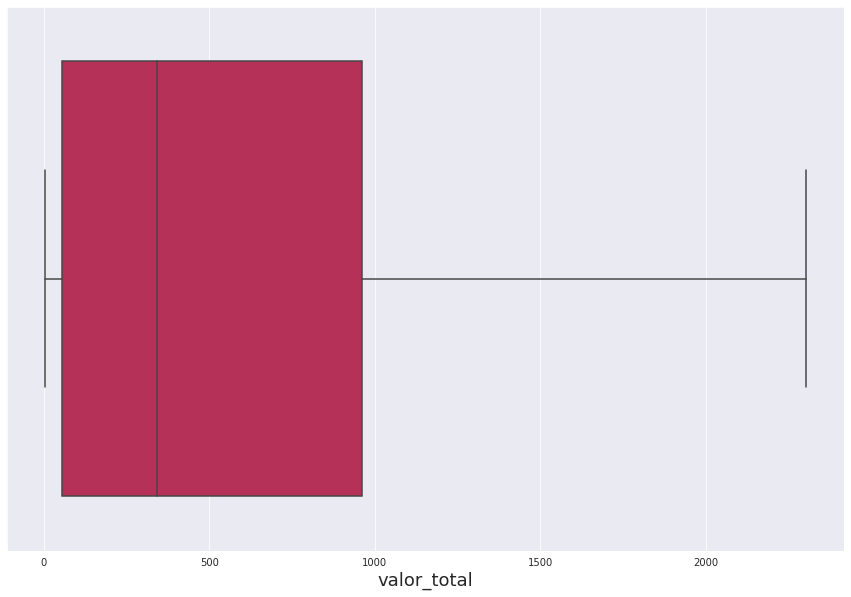

In [244]:
g_boxplot(df2, 'valor_total')

## Total de campanhas
- importante para analisar engajamento do cliente
- num_total_campanhas

In [245]:
df2.columns

Index(['id', 'grau_educacao', 'estado_civil', 'renda_anual', 'num_criancas',
       'num_adolescentes', 'recencia', 'valor_vinhos', 'valor_frutas',
       'valor_carnes', 'valor_peixes', 'valor_doces', 'valor_gold',
       'num_compras_promo', 'num_compras_web', 'num_compras_catalogo',
       'num_compras_loja', 'num_visitas_web', 'campanha_3', 'campanha_4',
       'campanha_5', 'campanha_1', 'campanha_2', 'reclamou', 'custo_contato',
       'receita_contato', 'resposta', 'idade', 'idade_grupo',
       'num_dependentes', 'recencia_grupo', 'num_total_compras',
       'num_compras_grupo', 'valor_total'],
      dtype='object')

In [246]:
df2['num_total_campanhas'] = df2.campanha_3 + df2.campanha_4 + df2.campanha_5 + df2.campanha_1 + df2.campanha_2

In [247]:
df2.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras,num_compras_grupo,valor_total,num_total_campanhas
1967,3595,Graduation,Married,"77,226.00",0,1,29,631,43,239,128,76,21,2,6,8,12,3,0,0,0,0,0,0,3,11,0,51,50-57,1,Recente,26,Alto,1117,0
344,8234,Basic,Married,"27,190.00",1,0,13,1,6,7,0,1,3,1,1,0,2,8,1,0,0,0,0,0,3,11,1,40,39-43,1,Muito recente,3,Muito pouco,15,1
895,9224,PhD,Single,"55,260.00",0,1,81,825,8,53,11,0,242,2,8,10,5,6,0,0,0,0,0,0,3,11,0,40,39-43,1,Inativo,23,Alto,897,0
1398,3421,Master,Divorced,"63,841.00",0,1,64,635,15,100,20,7,131,1,9,3,9,6,0,0,0,0,0,0,3,11,0,45,44-49,1,Meio recente,21,Alto,777,0
713,1044,Graduation,Married,"58,398.00",0,0,44,299,5,201,21,21,49,3,5,4,8,4,0,0,0,0,0,0,3,11,0,60,58-73,0,Recente,17,Medio,547,0


In [248]:
df2.num_total_campanhas.describe()

count   2,195.00
mean        0.30
std         0.68
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         4.00
Name: num_total_campanhas, dtype: float64

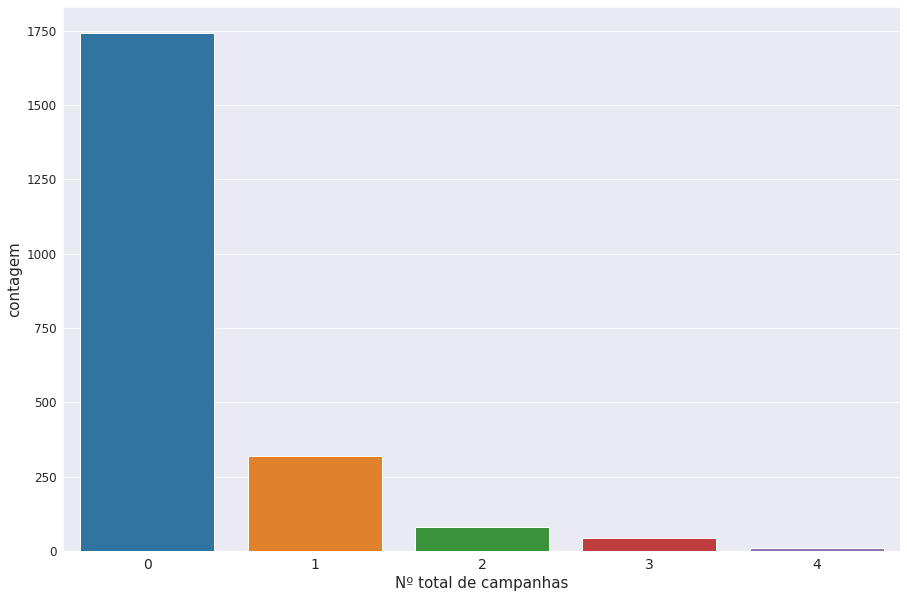

In [249]:
g_contagem(df2, 'num_total_campanhas', 'Nº total de campanhas', 'contagem')

In [250]:
df2.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras,num_compras_grupo,valor_total,num_total_campanhas
891,7108,Master,Widow,"51,390.00",1,1,54,205,20,47,23,2,56,6,5,2,5,5,0,0,0,0,0,0,3,11,0,47,44-49,2,Meio recente,12,Pouco,297,0
2003,6679,Graduation,Single,"33,279.00",0,0,29,10,3,3,0,0,0,1,0,0,3,3,0,0,0,0,0,0,3,11,0,48,44-49,0,Recente,3,Muito pouco,16,0
226,7375,Graduation,Married,"51,369.00",0,1,84,297,7,79,0,11,182,2,8,2,4,8,0,0,0,0,0,0,3,11,0,36,33-38,1,Inativo,14,Medio,394,0
255,5304,PhD,Single,"30,899.00",1,0,35,24,0,8,0,0,1,2,1,0,3,6,0,0,0,0,0,0,3,11,0,38,33-38,1,Recente,4,Muito pouco,32,0
1724,1381,PhD,Single,"38,513.00",1,0,20,172,3,115,16,0,18,5,6,1,5,8,0,0,0,0,0,0,3,11,1,32,18-32,1,Muito recente,12,Pouco,306,0


## Ticket médio
- importante ter esse indicador que mostra o comportamento do cliente


In [251]:
df2['ticket_medio'] = df2.valor_total / df2.num_total_compras

In [252]:
df2.ticket_medio.describe()

count   2,195.00
mean         inf
std          NaN
min         1.52
25%        10.25
50%        26.36
75%        44.26
max          inf
Name: ticket_medio, dtype: float64

In [253]:
np.isinf(df2.ticket_medio).sum()

4

In [254]:
# Dados inconsistentes
df2[df2.num_total_compras == 0]

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras,num_compras_grupo,valor_total,num_total_campanhas,ticket_medio
981,3955,Graduation,Divorced,"4,861.00",0,0,20,2,1,1,1,0,1,0,0,0,0,14,0,0,0,0,0,0,3,11,0,49,44-49,0,Muito recente,0,Muito pouco,5,0,inf
1245,6862,Graduation,Divorced,"1,730.00",0,0,65,1,1,3,1,1,1,15,0,0,0,20,0,0,0,0,0,0,3,11,0,43,39-43,0,Meio recente,0,Muito pouco,7,0,inf
1524,11110,Graduation,Single,"3,502.00",1,0,56,2,1,1,0,0,1,0,0,0,0,14,0,0,0,0,0,0,3,11,0,40,39-43,1,Meio recente,0,Muito pouco,4,0,inf
1846,9931,PhD,Married,"4,023.00",1,1,29,5,0,1,1,1,1,15,0,0,0,19,0,0,0,0,0,0,3,11,0,51,50-57,2,Recente,0,Muito pouco,8,0,inf


In [255]:
# excluir os dados acima
df2.drop(df2[df2.num_total_compras == 0].index, inplace = True)

# Seleção de variáveis

In [256]:
df3 = df2.copy()

In [257]:
df3.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,reclamou,custo_contato,receita_contato,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras,num_compras_grupo,valor_total,num_total_campanhas,ticket_medio
2089,7901,Master,Married,"34,109.00",0,1,39,9,1,5,2,1,4,1,0,0,3,4,0,0,0,0,0,0,3,11,0,42,39-43,1,Recente,3,Muito pouco,18,0,6.00
1741,7610,Graduation,Married,"37,292.00",1,0,32,275,0,86,10,23,66,5,6,3,5,8,0,0,0,0,0,0,3,11,0,30,18-32,1,Recente,14,Medio,394,0,28.14
193,1324,Graduation,Married,"38,872.00",1,0,93,23,3,21,3,19,22,2,3,0,3,8,0,0,0,0,0,0,3,11,0,25,18-32,1,Inativo,6,Muito pouco,69,0,11.50
1970,6281,Graduation,Divorced,"55,686.00",0,1,27,673,0,199,37,47,26,2,6,3,5,4,1,0,0,0,0,0,3,11,0,47,44-49,1,Recente,14,Medio,956,1,68.29
1860,1459,PhD,Married,"69,063.00",0,1,16,666,35,124,69,8,26,1,5,3,5,3,0,0,0,0,0,0,3,11,0,46,44-49,1,Muito recente,13,Medio,902,0,69.38


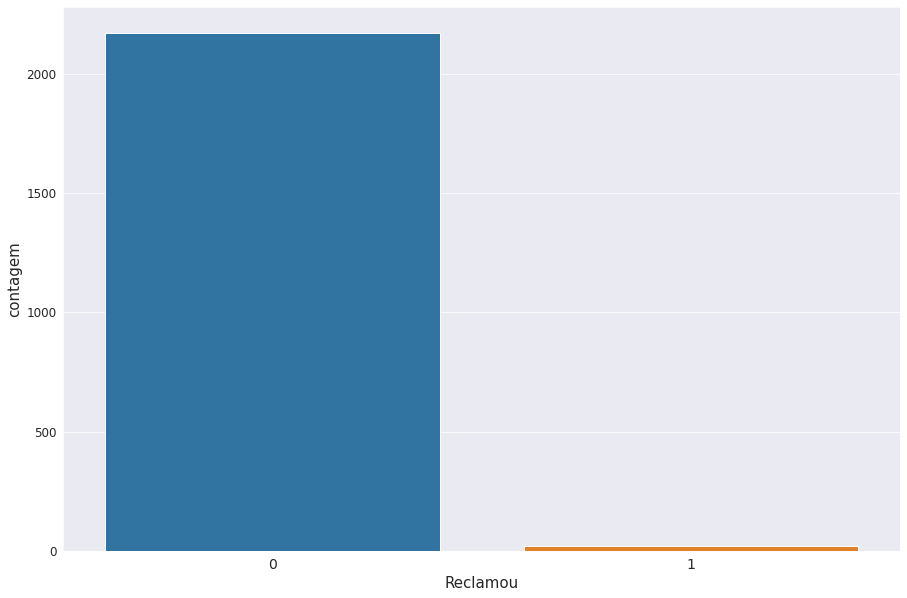

In [258]:
g_contagem(df3, 'reclamou', 'Reclamou', 'contagem')

Vou excluir essa variável pois está muito desbalanceada, e acredito que usar SMOTE ou UNDERSAMPLING pode não ser eficiente visto que a base de dados é pequena

In [259]:
# excluir variável pois tem apenas um único valor para todos os registros
df3.custo_contato.unique()

array([3])

In [260]:
# excluir variável pois tem apenas um único valor para todos os registros
df3.receita_contato.unique()

array([11])

In [261]:
cols_drop = ['reclamou', 'custo_contato', 'receita_contato']

In [262]:
df3 = df3.drop(cols_drop, axis=1)

In [263]:
df3.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras,num_compras_grupo,valor_total,num_total_campanhas,ticket_medio
2200,7620,Basic,Single,"16,185.00",1,0,71,5,11,16,21,8,45,2,2,2,2,8,0,0,0,0,0,0,23,18-32,1,Meio recente,6,Muito pouco,61,0,10.17
7,6177,PhD,Married,"33,454.00",1,0,32,76,10,56,3,1,23,2,4,0,4,8,0,0,0,0,0,0,28,18-32,1,Recente,8,Pouco,146,0,18.25
356,2061,Graduation,Married,"50,737.00",0,1,61,78,0,11,0,0,10,1,2,0,4,6,0,1,0,0,0,0,58,58-73,1,Meio recente,6,Muito pouco,89,1,14.83
757,5909,Graduation,Married,"58,512.00",0,1,25,895,10,101,13,0,152,5,3,4,8,8,0,0,0,0,0,0,49,44-49,1,Recente,15,Medio,1019,0,67.93
574,7369,Master,Married,"36,959.00",1,0,56,25,6,25,6,0,0,2,2,0,3,8,0,0,0,0,0,0,32,18-32,1,Meio recente,5,Muito pouco,62,0,12.40


# EDA

In [264]:
df4 = df3.copy()

## Análise Univariada

### Variável resposta

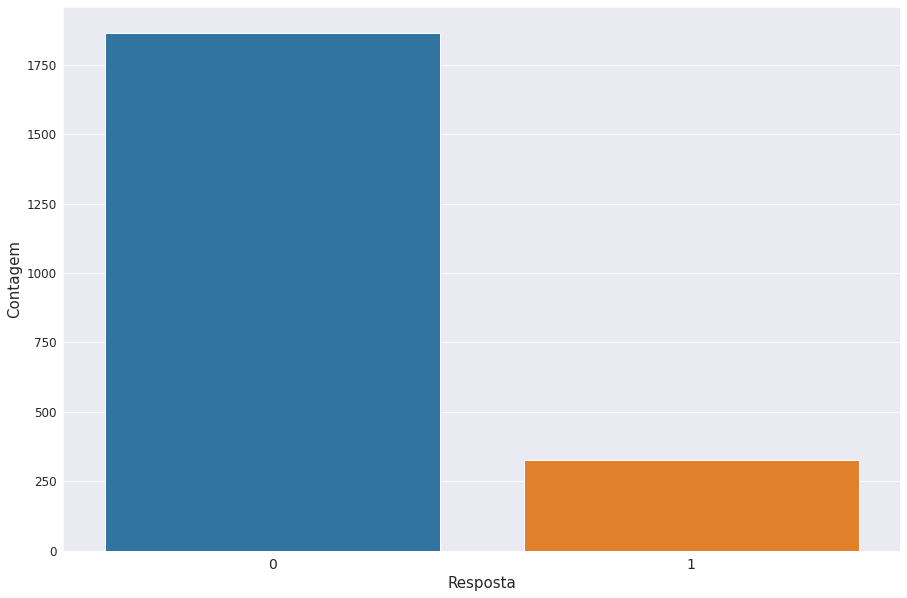

In [265]:
g_contagem(df4, 'resposta', 'Resposta', 'Contagem')

### Variáveis numericas

In [266]:
variaveis_num = df4.select_dtypes(include=['int64', 'float64'])

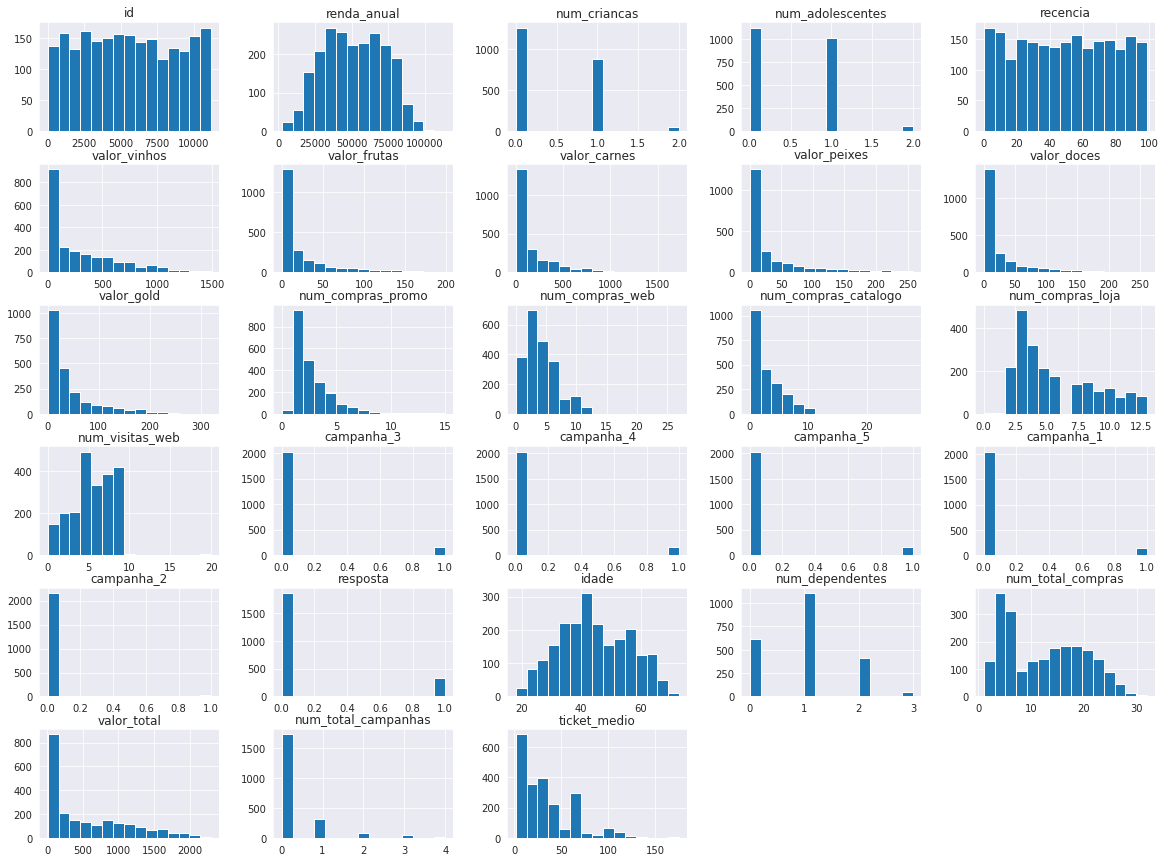

In [267]:
variaveis_num.hist(bins=15, figsize=(20,15))
plt.show()

## Análise Multivariada

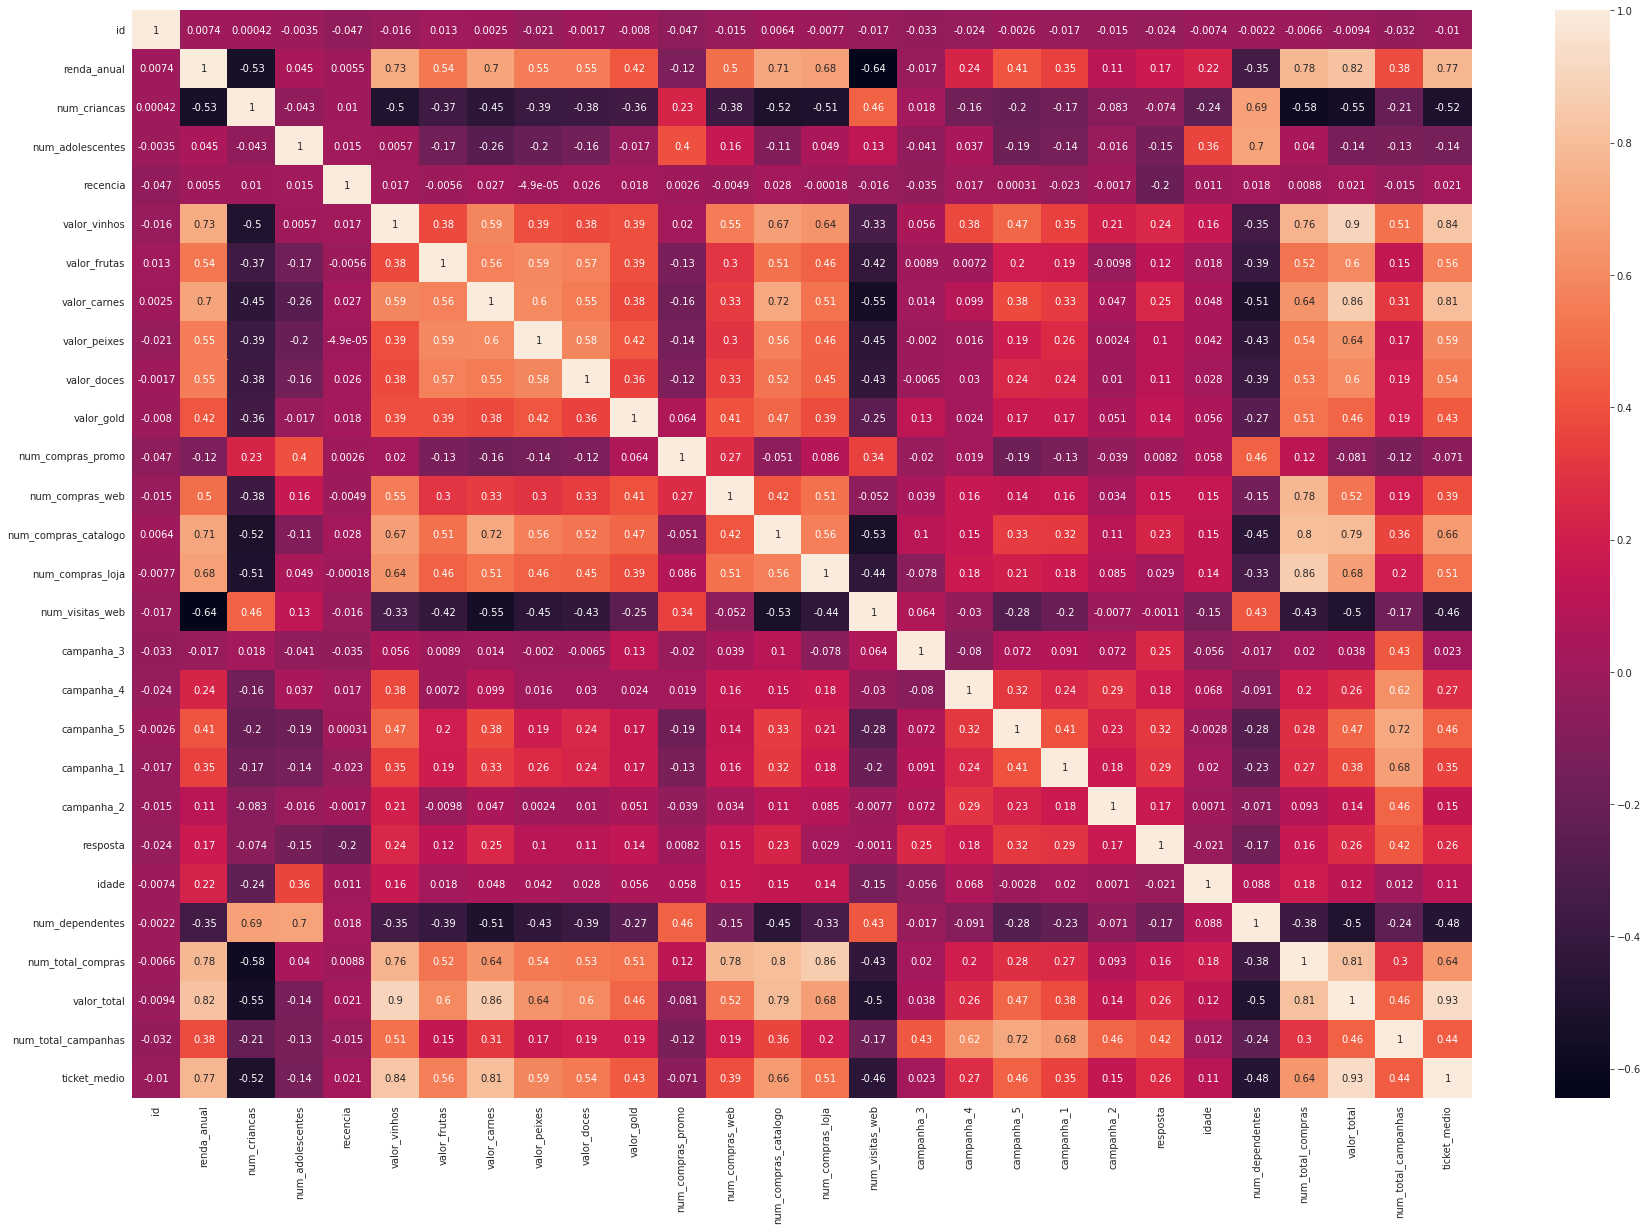

In [268]:
corr = variaveis_num.corr(method='pearson')

plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True);

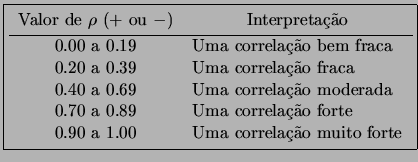


Renda Anual x Valor total em compras: 0.82 tem uma correlação forte
- O Cliente no qual tem um renda anual maior, tende é ter um gasto maior em compras

<br>

Valor total tem correlações forte, além da Renda Anual com:
- Valor gasto em vinhos: 0.9 correlação muito forte
- Valor gasto em carnes: 0.86 correlação forte
- Nº de compras no catálogo: 0.79 correlação forte
- Nº de compras na loja: 0.68 correlação moderada
- Nº de compras na promoção: Correlação negativa
- Nº de dependentes: Correlação negativa

Ou seja, os clientes que mais gastaram, compraram principalmente vinhos e carnes.
Fizeram compras pelo catálogo ou direto na loja, e nem precisavam de uma promoção, além de não ter dependentes.

<br>

Clientes que tem dependentes:
- Tem uma renda anual menor
- Compram menos
- Compram mais em promoção

<br>

Clientes X Resposta:
- Aceitaram ofertas anteriores principalmente a campanha 5.
- Compram mais utilizando o catálogo
- Vinhos e carnes ainda são os produtos que mais compram



In [269]:
df4.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras,num_compras_grupo,valor_total,num_total_campanhas,ticket_medio
1510,486,Graduation,Married,"84,219.00",0,0,27,434,137,400,45,137,45,1,3,4,10,1,0,0,0,0,0,0,26,18-32,0,Recente,17,Medio,1153,0,67.82
2220,6261,Graduation,Married,"58,025.00",0,1,81,270,31,88,11,48,22,3,3,2,10,4,0,0,0,0,0,0,34,33-38,1,Inativo,15,Medio,448,0,29.87
781,10839,Graduation,Married,"36,283.00",1,1,42,6,5,5,8,0,5,2,1,0,3,4,0,0,0,0,0,0,38,33-38,2,Recente,4,Muito pouco,24,0,6.00
1053,5740,Master,Divorced,"25,959.00",1,1,1,4,2,12,7,5,26,2,1,2,2,6,0,0,0,0,0,1,43,39-43,2,Muito recente,5,Muito pouco,30,0,6.00
480,5300,Master,Married,"38,961.00",1,0,60,19,7,19,0,1,24,1,2,1,2,7,0,0,0,0,0,0,40,39-43,1,Meio recente,5,Muito pouco,46,0,9.20


# Preparação dos Dados

In [270]:
df5 = df4.copy()

# Conhecer sobre os clientes que aceitaram a Campanha Nº 6

In [272]:
df6 = df5.copy()

In [273]:
aceitou = df5[df5.resposta == 1]
recusou = df5[df5.resposta == 0]

In [274]:
aceitou.describe()

,id,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,resposta,idade,num_dependentes,num_total_compras,valor_total,num_total_campanhas,ticket_medio
count,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00,327.00
mean,"5,398.54","60,101.14",0.35,0.31,35.20,500.38,37.28,291.48,51.26,37.59,60.75,2.35,5.08,4.17,6.05,5.31,0.23,0.19,0.27,0.24,0.06,1.00,43.62,0.66,15.29,918.00,0.98,51.93
std,"3,152.65","23,043.68",0.49,0.49,27.71,427.15,45.31,284.88,61.38,45.57,57.04,2.12,2.58,3.10,3.06,2.55,0.42,0.39,0.44,0.42,0.24,0.00,12.07,0.74,6.80,692.38,1.12,36.22
min,1.00,"7,500.00",0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,18.00,0.00,3.00,14.00,0.00,4.50
25%,"2,748.00","39,723.50",0.00,0.00,11.00,93.50,4.00,47.00,4.00,3.00,20.00,1.00,3.00,1.00,4.00,3.00,0.00,0.00,0.00,0.00,0.00,1.00,35.00,0.00,10.00,217.50,0.00,20.27
50%,"5,093.00","63,998.00",0.00,0.00,30.00,437.00,21.00,170.00,25.00,20.00,39.00,1.00,5.00,4.00,6.00,6.00,0.00,0.00,0.00,0.00,0.00,1.00,42.00,1.00,16.00,961.00,1.00,42.33
75%,"8,112.50","80,137.50",1.00,1.00,56.00,869.00,52.00,502.00,80.00,55.00,83.50,3.00,7.00,6.00,8.00,8.00,0.00,0.00,1.00,0.00,0.00,1.00,54.00,1.00,20.00,"1,517.00",2.00,72.86
max,"11,084.00","105,471.00",2.00,2.00,99.00,"1,492.00",193.00,981.00,250.00,198.00,241.00,11.00,11.00,11.00,13.00,10.00,1.00,1.00,1.00,1.00,1.00,1.00,70.00,3.00,32.00,"2,304.00",4.00,175.42


In [275]:
recusou.describe()

,id,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,resposta,idade,num_dependentes,num_total_compras,valor_total,num_total_campanhas,ticket_medio
count,"1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00","1,864.00"
mean,"5,613.81","50,148.93",0.46,0.54,51.52,271.14,24.32,141.95,35.23,25.13,40.99,2.30,3.94,2.37,5.79,5.32,0.05,0.05,0.04,0.03,0.01,0.00,44.30,1.00,12.09,497.76,0.18,30.94
std,"3,263.07","19,748.21",0.54,0.55,28.50,305.57,38.22,193.34,53.08,39.82,50.02,1.80,2.73,2.64,3.26,2.32,0.21,0.23,0.19,0.18,0.07,0.00,11.63,0.74,7.12,524.14,0.47,26.06
min,0.00,"2,447.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.00,0.00,1.00,6.00,0.00,1.52
25%,"2,828.25","34,418.75",0.00,0.00,27.00,22.00,1.00,14.00,2.00,1.00,7.75,1.00,2.00,0.00,3.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,36.00,1.00,5.00,50.00,0.00,9.75
50%,"5,522.00","50,065.00",0.00,1.00,52.00,154.50,7.00,57.00,11.00,7.00,21.00,2.00,3.00,1.00,5.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,43.00,1.00,11.00,273.00,0.00,24.52
75%,"8,446.75","65,876.50",1.00,1.00,77.00,446.25,29.00,190.00,43.25,30.00,53.00,3.00,6.00,4.00,8.00,7.00,0.00,0.00,0.00,0.00,0.00,0.00,54.00,1.00,18.00,881.50,0.00,39.76
max,"11,191.00","113,734.00",2.00,2.00,99.00,"1,493.00",199.00,"1,725.00",259.00,262.00,321.00,15.00,27.00,28.00,13.00,20.00,1.00,1.00,1.00,1.00,1.00,0.00,73.00,3.00,32.00,"2,262.00",4.00,176.00


Na média os Clientes que aceitaram a 6ª Campanha:
- Tem uma renda anual maior
- Fizeram compras recentemente
- Tem menos dependentes
- Fizeram mais compras (de forma mais frequente)
- Gastaram mais em suas compras, consequentemente um ticket médio maior
- Aceitaram mais ofertas anteriormente
- Fizeram as compras principalmente nas loja



# Segmentação de cliente - RFM




> Recência (R)
- Há quantos dias foi a última compra do cliente?





> Frequência (F)
- Quantas compras esse cliente fez?





> Valor Monetário (M)
- Quanto esse cliente já gastou?



## Selecão das variáveis

In [276]:
segmentacao = df6[['id', 'recencia', 'num_total_compras', 'valor_total']].rename(columns= {
    'num_total_compras': 'frequencia',
    'valor_total': 'monetario'
})

In [277]:
segmentacao.sample(5)

,id,recencia,frequencia,monetario
467,9213,13,3,12
1673,3433,54,20,874
574,7369,56,5,62
1823,9166,57,20,720
1156,967,11,16,496


## Criar pontuação para cada variável
- Recência
- Frequência
- Valor monetário

In [278]:
segmentacao = determinar_subdivisao(segmentacao, 'recencia', True, 'r_pontuacao')
segmentacao = determinar_subdivisao(segmentacao, 'frequencia', False, 'f_pontuacao')
segmentacao = determinar_subdivisao(segmentacao, 'recencia', False, 'm_pontuacao')

In [279]:
segmentacao.sample(5)

,id,recencia,frequencia,monetario,r_pontuacao,f_pontuacao,m_pontuacao
697,2868,33,5,55,2,4,3
2115,9907,80,24,956,4,1,1
1423,5229,81,4,39,4,4,1
950,7574,80,5,30,4,4,1
897,5046,97,23,1577,4,1,1


## Criar grupo para identificar melhor a que segmento o cliente pertence

In [280]:
segmentacao['rfm_grupo'] = segmentacao.r_pontuacao.map(str) + segmentacao.f_pontuacao.map(str) + segmentacao.m_pontuacao.map(str)

In [281]:
segmentacao.sample(5)

,id,recencia,frequencia,monetario,r_pontuacao,f_pontuacao,m_pontuacao,rfm_grupo
793,11075,37,11,258,2,3,3,233
1356,7912,69,6,70,3,4,2,342
1842,7419,90,5,32,4,4,1,441
265,6690,30,7,70,2,3,3,233
1308,5758,23,27,1143,1,1,4,114


## Criando variável de pontução geral

In [282]:
segmentacao['rfm_pontuacao'] = segmentacao.r_pontuacao + segmentacao.f_pontuacao + segmentacao.m_pontuacao

In [283]:
segmentacao.sample(5)

,id,recencia,frequencia,monetario,r_pontuacao,f_pontuacao,m_pontuacao,rfm_grupo,rfm_pontuacao
1689,295,77,21,1073,4,1,1,411,6
1659,2781,55,16,1758,3,2,2,322,7
504,10160,49,4,40,2,4,3,243,9
1987,4552,37,11,276,2,3,3,233,8
1358,1065,85,18,1900,4,2,1,421,7


## Dando nome para cada segmento

In [284]:
segmentacao['fidelidade'] = 'inativo'
segmentacao.loc[segmentacao.rfm_pontuacao == 6, 'fidelidade'] = 'black'
segmentacao.loc[segmentacao.rfm_pontuacao == 7, 'fidelidade'] = 'platinum'
segmentacao.loc[segmentacao.rfm_pontuacao == 8, 'fidelidade'] = 'gold'
segmentacao.loc[segmentacao.rfm_pontuacao == 9, 'fidelidade'] = 'silver'

In [285]:
segmentacao.sample(5)

,id,recencia,frequencia,monetario,r_pontuacao,f_pontuacao,m_pontuacao,rfm_grupo,rfm_pontuacao,fidelidade
2076,6958,42,4,18,2,4,3,243,9,silver
921,4483,67,18,1046,3,2,2,322,7,platinum
1651,8395,48,21,1480,2,1,3,213,6,black
457,3225,71,10,219,3,3,2,332,8,gold
948,6515,92,5,36,4,4,1,441,9,silver


In [286]:
segmentacao.rfm_grupo.unique()

array(['312', '243', '213', '421', '114', '223', '233', '144', '342',
       '332', '134', '411', '441', '322', '124', '431'], dtype=object)

In [287]:
# 411, 312, 213, 114 = 6

### Melhores clientes

In [288]:
segmentacao.query('rfm_grupo in ("411","312","213","114")').sort_values('monetario', ascending=False)

,id,recencia,frequencia,monetario,r_pontuacao,f_pontuacao,m_pontuacao,rfm_grupo,rfm_pontuacao,fidelidade
987,4580,46,25,2304,2,1,3,213,6,black
1458,10133,16,25,2304,1,1,4,114,6,black
1052,4475,82,24,2262,4,1,1,411,6,black
1601,5453,26,23,2244,2,1,3,213,6,black
1992,6248,47,27,2169,2,1,3,213,6,black
...,...,...,...,...,...,...,...,...,...,...
1000,10473,38,19,490,2,1,3,213,6,black
1087,1509,80,22,442,4,1,1,411,6,black
1898,4619,9,27,274,1,1,4,114,6,black
1806,6237,92,25,125,4,1,1,411,6,black


## Análise gráfica

### Gráficos de dispersão

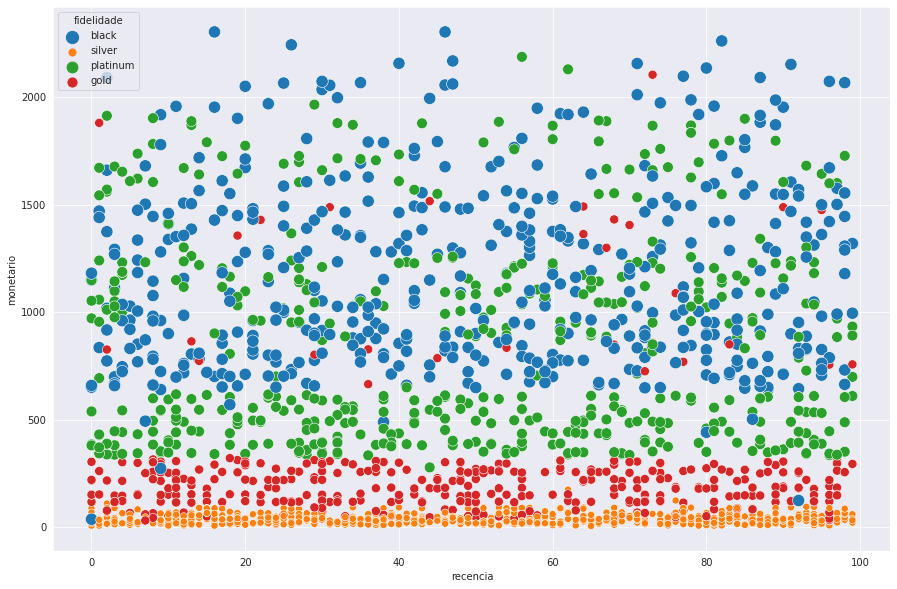

In [289]:
g_scatter_segmento(segmentacao, 'recencia', 'monetario')

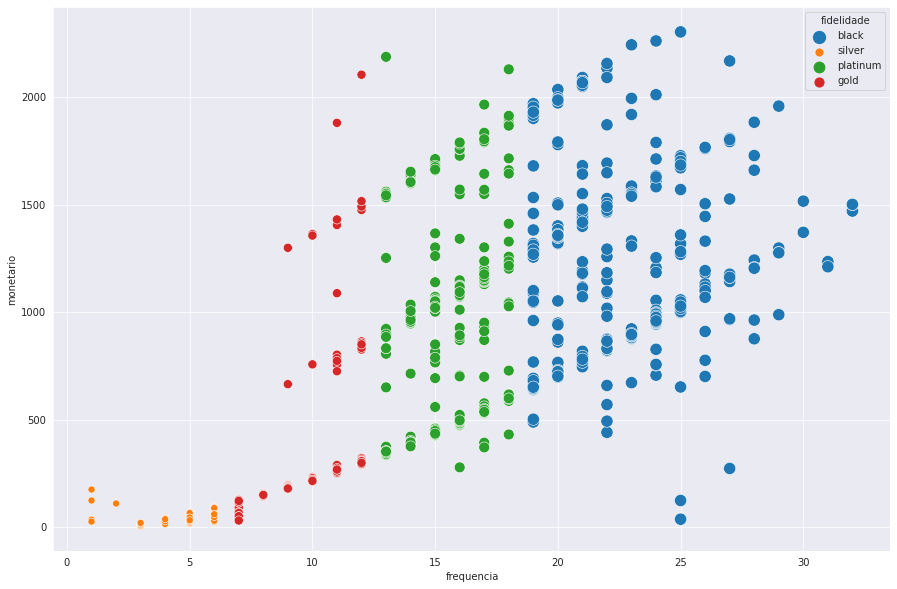

In [290]:
g_scatter_segmento(segmentacao, 'frequencia', 'monetario')

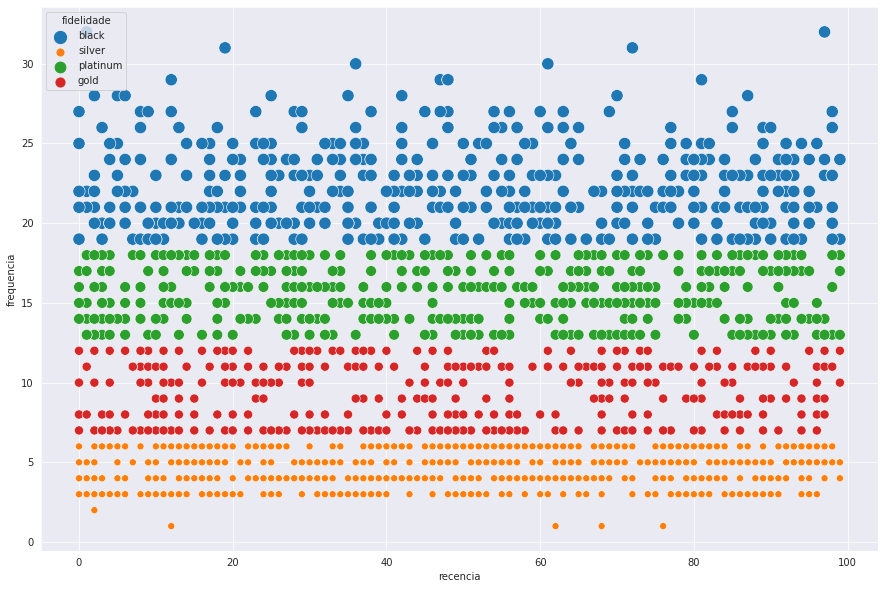

In [291]:
g_scatter_segmento(segmentacao, 'recencia', 'frequencia')

### Análises dos segmentos

In [292]:
segmentacao

,id,recencia,frequencia,monetario,r_pontuacao,f_pontuacao,m_pontuacao,rfm_grupo,rfm_pontuacao,fidelidade
0,5524,58,22,1529,3,1,2,312,6,black
1,2174,38,4,21,2,4,3,243,9,silver
2,4141,26,20,734,2,1,3,213,6,black
3,6182,26,6,48,2,4,3,243,9,silver
4,5324,94,14,407,4,2,1,421,7,platinum
...,...,...,...,...,...,...,...,...,...,...
2235,10870,46,16,1094,2,2,3,223,7,platinum
2236,4001,56,15,436,3,2,2,322,7,platinum
2237,7270,91,18,1217,4,2,1,421,7,platinum
2238,8235,8,21,782,1,1,4,114,6,black


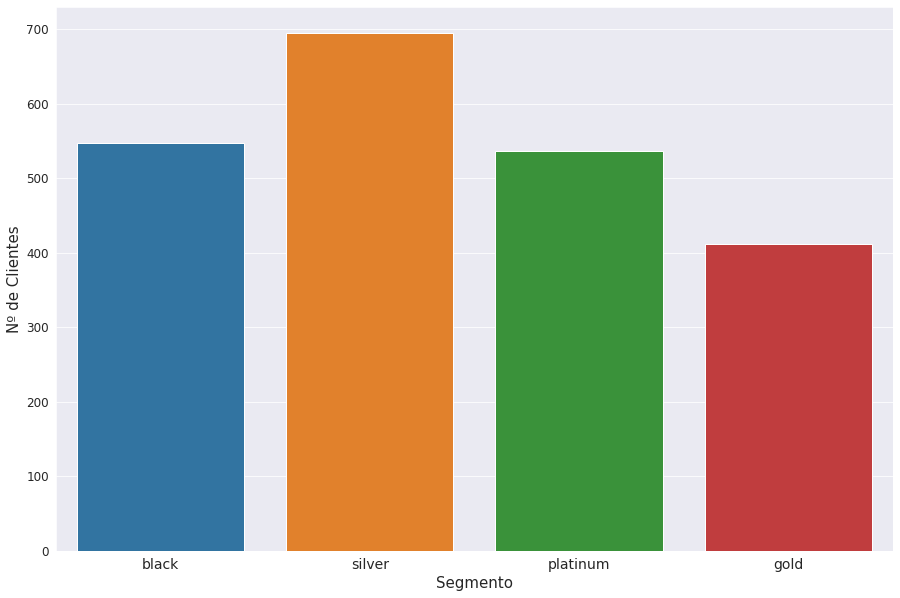

In [293]:
g_contagem(segmentacao, 'fidelidade', 'Segmento', 'Nº de Clientes')

In [305]:
df7 = pd.merge(df6, segmentacao[['id', 'r_pontuacao', 'f_pontuacao', 'm_pontuacao', 'rfm_grupo', 'rfm_pontuacao', 'fidelidade']], on='id')

In [306]:
df7.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras,num_compras_grupo,valor_total,num_total_campanhas,ticket_medio,r_pontuacao,f_pontuacao,m_pontuacao,rfm_grupo,rfm_pontuacao,fidelidade
2071,3969,Master,Married,"43,018.00",0,1,46,35,4,17,7,6,64,1,2,2,2,5,0,0,0,0,0,0,39,39-43,1,Recente,6,Muito pouco,69,0,11.50,2,4,3,243,9,silver
1616,6409,Graduation,Divorced,"57,136.00",0,0,18,267,140,599,34,12,127,1,7,5,7,6,0,0,0,0,0,1,46,44-49,0,Muito recente,19,Alto,1052,0,55.37,1,1,4,114,6,black
248,9396,PhD,Married,"37,717.00",1,0,31,9,0,6,4,1,5,1,1,0,2,9,0,0,0,0,0,0,34,33-38,1,Recente,3,Muito pouco,20,0,6.67,2,4,3,243,9,silver
841,9553,Graduation,Married,"7,500.00",0,0,94,0,2,3,4,1,5,1,0,0,3,6,0,0,0,0,0,0,26,18-32,0,Inativo,3,Muito pouco,10,0,3.33,4,4,1,441,9,silver
1911,10676,Graduation,Married,"63,211.00",0,0,3,145,193,459,205,26,145,2,3,8,7,2,0,0,0,0,0,1,30,18-32,0,Muito recente,18,Medio,1028,0,57.11,1,2,4,124,7,platinum


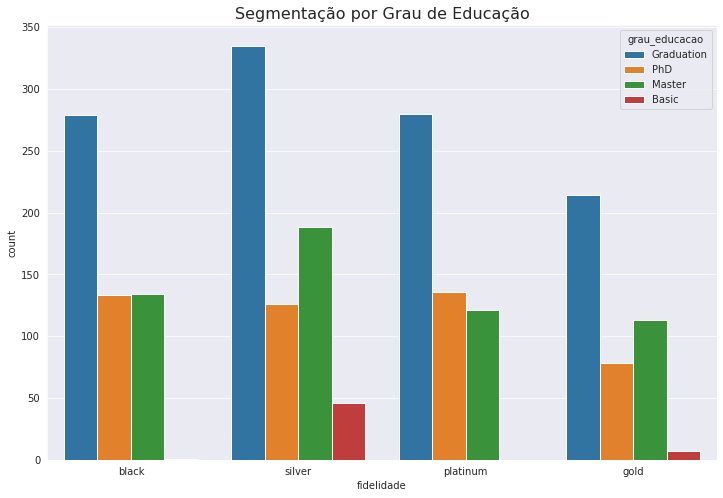

In [307]:
plt.figure(figsize=(12,8))

sns.countplot(x='fidelidade', data=df7, hue='grau_educacao')
plt.title('Segmentação por Grau de Educação', fontsize=16)
plt.show()

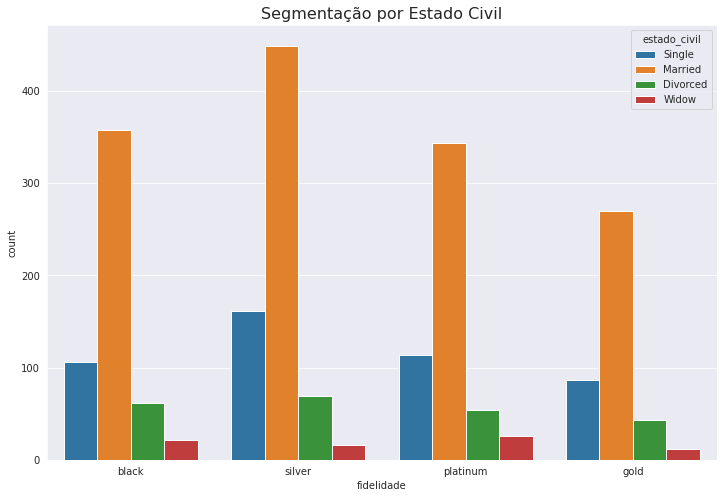

In [308]:
plt.figure(figsize=(12,8))

sns.countplot(x='fidelidade', data=df7, hue='estado_civil')
plt.title('Segmentação por Estado Civil', fontsize=16)
plt.show()

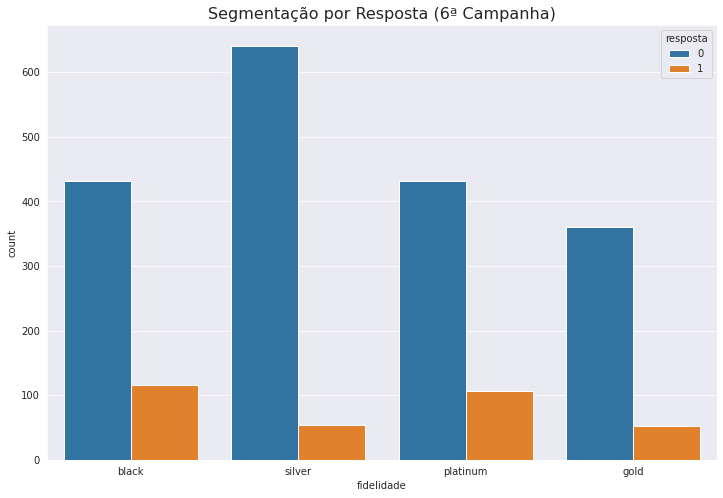

In [309]:
plt.figure(figsize=(12,8))

sns.countplot(x='fidelidade', data=df7, hue='resposta')
plt.title('Segmentação por Resposta (6ª Campanha)', fontsize=16)
plt.show()

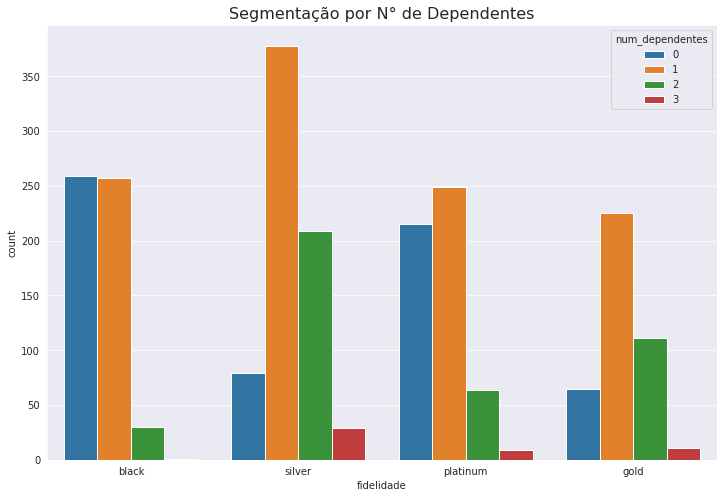

In [310]:
plt.figure(figsize=(12,8))

sns.countplot(x='fidelidade', data=df7, hue='num_dependentes')
plt.title('Segmentação por N° de Dependentes', fontsize=16)
plt.show()

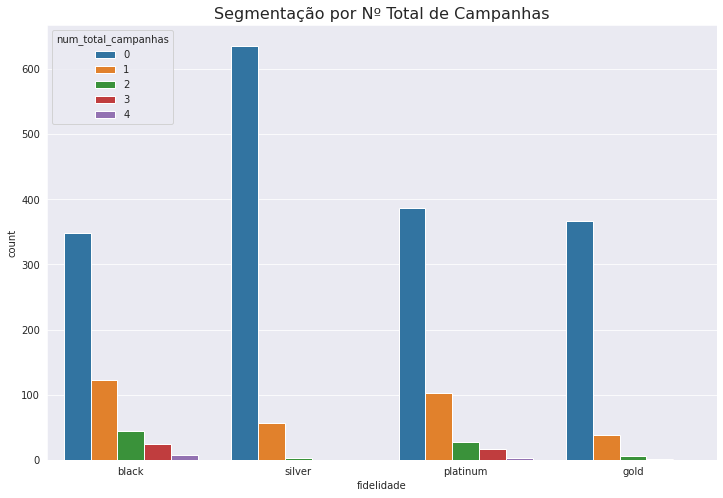

In [311]:
plt.figure(figsize=(12,8))

sns.countplot(x='fidelidade', data=df7, hue='num_total_campanhas')
plt.title('Segmentação por Nº Total de Campanhas', fontsize=16)
plt.show()

In [312]:
df7[df7.fidelidade == 'black'].describe()

,id,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,resposta,idade,num_dependentes,num_total_compras,valor_total,num_total_campanhas,ticket_medio,r_pontuacao,f_pontuacao,m_pontuacao,rfm_pontuacao
count,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00,547.00
mean,"5,580.30","70,571.07",0.09,0.50,49.56,639.73,53.59,345.86,75.07,55.52,74.54,2.29,6.74,5.76,9.73,4.14,0.09,0.13,0.17,0.16,0.03,0.21,46.31,0.59,22.22,"1,169.79",0.58,53.10,2.50,1.00,2.50,6.00
std,"3,072.03","12,462.71",0.29,0.54,29.17,286.89,48.46,238.84,63.96,50.16,59.85,2.18,2.70,2.70,2.62,2.13,0.28,0.34,0.38,0.37,0.16,0.41,11.92,0.60,2.64,417.06,0.93,19.74,1.13,0.00,1.13,0.00
min,17.00,"2,447.00",0.00,0.00,0.00,1.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.00,0.00,19.00,38.00,0.00,1.52,1.00,1.00,1.00,6.00
25%,"3,120.00","62,807.00",0.00,0.00,24.00,429.00,17.00,157.50,23.00,16.00,29.00,1.00,5.00,4.00,8.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,37.00,0.00,20.00,827.50,0.00,38.07,1.00,1.00,1.00,6.00
50%,"5,462.00","70,379.00",0.00,0.00,50.00,611.00,35.00,271.00,58.00,38.00,56.00,1.00,6.00,5.00,10.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,46.00,1.00,22.00,"1,073.00",0.00,42.89,3.00,1.00,2.00,6.00
75%,"8,191.50","78,878.00",0.00,1.00,76.00,825.50,80.00,467.50,115.50,88.50,107.00,3.00,8.00,7.00,12.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,56.00,1.00,24.00,"1,466.00",1.00,67.61,4.00,1.00,4.00,6.00
max,"11,112.00","113,734.00",2.00,2.00,99.00,"1,492.00",199.00,"1,725.00",259.00,262.00,321.00,15.00,27.00,28.00,13.00,9.00,1.00,1.00,1.00,1.00,1.00,1.00,72.00,3.00,32.00,"2,304.00",4.00,103.68,4.00,1.00,4.00,6.00


In [313]:
df7[df7.fidelidade == 'silver'].describe()

,id,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,resposta,idade,num_dependentes,num_total_compras,valor_total,num_total_campanhas,ticket_medio,r_pontuacao,f_pontuacao,m_pontuacao,rfm_pontuacao
count,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00,695.00
mean,"5,663.34","31,798.05",0.83,0.44,48.84,18.25,3.27,12.03,4.72,3.33,10.45,1.63,1.51,0.28,2.81,6.50,0.08,0.00,0.00,0.00,0.00,0.08,41.16,1.27,4.60,41.60,0.09,9.01,2.49,4.00,2.51,9.00
std,"3,254.25","10,826.09",0.47,0.53,28.97,17.08,4.67,8.15,5.98,4.65,13.72,0.94,0.75,0.50,0.65,1.86,0.27,0.07,0.00,0.00,0.05,0.27,10.83,0.71,1.10,22.58,0.29,8.61,1.14,0.00,1.14,0.00
min,13.00,"5,305.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,18.00,0.00,1.00,6.00,0.00,2.00,1.00,4.00,1.00,9.00
25%,"2,690.00","23,933.50",1.00,0.00,24.00,5.50,0.00,6.00,0.00,0.00,3.00,1.00,1.00,0.00,2.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,34.00,1.00,4.00,23.00,0.00,6.00,1.00,4.00,1.00,9.00
50%,"5,585.00","31,560.00",1.00,0.00,49.00,13.00,2.00,10.00,3.00,2.00,7.00,1.00,1.00,0.00,3.00,7.00,0.00,0.00,0.00,0.00,0.00,0.00,41.00,1.00,5.00,39.00,0.00,8.00,2.00,4.00,3.00,9.00
75%,"8,442.50","38,702.50",1.00,1.00,76.00,26.00,4.00,16.00,7.00,5.00,14.00,2.00,2.00,1.00,3.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,48.00,2.00,6.00,55.00,0.00,10.45,4.00,4.00,4.00,9.00
max,"11,188.00","64,587.00",2.00,2.00,99.00,107.00,36.00,66.00,41.00,30.00,262.00,15.00,3.00,2.00,4.00,20.00,1.00,1.00,0.00,0.00,1.00,1.00,67.00,3.00,6.00,176.00,2.00,176.00,4.00,4.00,4.00,9.00


In [314]:
df7.fidelidade.value_counts()

silver      695
black       547
platinum    537
gold        412
Name: fidelidade, dtype: int64

In [315]:
# Porcentagem dos clientes por segmento
df7.fidelidade.value_counts(normalize=True) * 100

silver     31.72
black      24.97
platinum   24.51
gold       18.80
Name: fidelidade, dtype: float64

Foram criado, 4 tipos de clientes:
- Black
- Platinum
- Gold
- Silver

E foi possível observar que tanto a frequência quanto o valor gasto, são mais importantes do que a recência, na comparação dos:

`Melhores Clientes - Black`:
- Grande maioria com no máximo 1 dependente
- Maior conversão na 6ª campanha
- Maior aceitação em totas as campanhas
- Renda anual maior
- Compra de forma mais frequente
- Compram muitos produtos das categorias vinhos e carnes além de produtos 'gold'
- Comprar principalmente direto nas lojas e pelo site
- Consequentemente fizeram mais compras e compras de maior valor

`Clientes menos engajados - Silver`:
- Renda anual menor
- Compram muitos produtos das categorias vinhos e carnes, mas em quantidades bem menores
- Visitam mais o site
- A maioria tem no mínimo 1 dependente
- A frequência e o Valor das compras são bem inferiores

# Modelo - Classificação

In [316]:
df8 = df7.copy()

In [317]:
df8.sample(3)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,resposta,idade,idade_grupo,num_dependentes,recencia_grupo,num_total_compras,num_compras_grupo,valor_total,num_total_campanhas,ticket_medio,r_pontuacao,f_pontuacao,m_pontuacao,rfm_grupo,rfm_pontuacao,fidelidade
1913,7842,Graduation,Single,"36,065.00",1,1,54,18,7,34,10,2,3,3,3,0,3,8,0,0,0,0,0,0,45,44-49,2,Meio recente,6,Muito pouco,71,0,11.83,3,4,2,342,9,silver
1350,8805,Graduation,Single,"48,904.00",0,1,1,283,10,38,0,13,27,4,7,2,4,8,0,0,0,0,0,0,52,50-57,1,Muito recente,13,Medio,344,0,26.46,1,2,4,124,7,platinum
1572,11092,Graduation,Married,"27,116.00",1,1,78,12,1,21,2,2,3,2,2,0,3,7,0,0,0,0,0,0,53,50-57,2,Inativo,5,Muito pouco,38,0,7.60,4,4,1,441,9,silver


In [320]:
# Selecionando apenas as colunas que me "interessam"
df8 = df8[['id', 'grau_educacao', 'estado_civil', 'renda_anual', 'num_criancas', 'num_adolescentes', 'recencia', 'valor_vinhos', 'valor_frutas', 'valor_carnes', 'valor_peixes', 
           'valor_doces', 'valor_gold', 'num_compras_promo', 'num_compras_web', 'num_compras_catalogo', 'num_compras_loja', 'num_visitas_web', 'campanha_3', 'campanha_4',
           'campanha_5', 'campanha_1', 'campanha_2', 'resposta', 'idade', 'num_total_compras', 'valor_total', 'num_total_campanhas', 'ticket_medio', 'r_pontuacao', 'f_pontuacao',
           'm_pontuacao', 'rfm_pontuacao']]

In [321]:
df8.sample(5)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,resposta,idade,num_total_compras,valor_total,num_total_campanhas,ticket_medio,r_pontuacao,f_pontuacao,m_pontuacao,rfm_pontuacao
1950,8619,Graduation,Married,"21,994.00",0,1,4,9,0,6,3,1,3,1,0,0,3,5,0,0,0,0,0,0,55,3,19,0,6.33,1,4,4,9
2112,8726,Master,Divorced,"41,713.00",1,1,57,77,8,44,10,10,25,5,3,1,4,6,0,0,0,0,0,0,50,8,149,0,18.62,3,3,2,8
320,4099,Graduation,Married,"30,675.00",1,0,14,10,2,16,11,2,21,1,1,0,3,8,0,0,0,0,0,0,40,4,41,0,10.25,1,4,4,9
1102,2308,Graduation,Married,"46,734.00",0,1,40,110,5,137,26,23,29,2,6,1,5,7,0,0,0,0,0,0,58,12,301,0,25.08,2,3,3,8
1927,6355,Graduation,Married,"44,359.00",1,1,19,20,0,14,7,3,1,3,2,0,4,3,0,0,0,0,0,0,36,6,44,0,7.33,1,4,4,9


## Preparação dos dados

In [322]:
le = LabelEncoder()
df8.estado_civil = le.fit_transform(df8.estado_civil)

df8.grau_educacao = df8.grau_educacao.map({
    'Basic': 0,
    'Graduation': 1,
    'Master': 2,
    'PhD': 3
})

In [323]:
df8.sample(4)

,id,grau_educacao,estado_civil,renda_anual,num_criancas,num_adolescentes,recencia,valor_vinhos,valor_frutas,valor_carnes,valor_peixes,valor_doces,valor_gold,num_compras_promo,num_compras_web,num_compras_catalogo,num_compras_loja,num_visitas_web,campanha_3,campanha_4,campanha_5,campanha_1,campanha_2,resposta,idade,num_total_compras,valor_total,num_total_campanhas,ticket_medio,r_pontuacao,f_pontuacao,m_pontuacao,rfm_pontuacao
2139,8207,2,1,"53,233.00",0,1,18,28,0,9,3,0,0,1,1,0,3,4,0,0,0,0,0,0,57,4,40,0,10.00,1,4,4,9
1229,961,1,1,"74,716.00",0,1,92,133,27,421,13,195,71,2,7,3,5,4,0,0,0,0,0,0,41,15,789,0,52.60,4,2,1,7
538,448,3,2,"54,880.00",1,0,57,308,85,137,102,45,118,2,6,2,11,5,0,0,0,0,0,0,35,19,677,0,35.63,3,1,2,6
1586,3011,1,1,"69,139.00",0,1,23,86,12,75,33,15,6,1,4,1,5,4,0,0,0,0,0,0,49,10,221,0,22.10,1,3,4,8


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


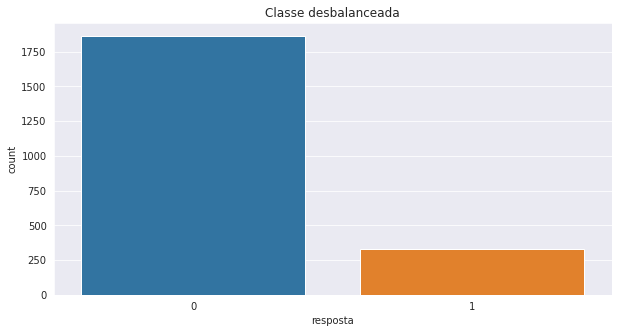

In [324]:
plt.figure(figsize=(10,5))

sns.countplot(df8.resposta)
plt.title('Classe desbalanceada')

plt.show()

## Criando modelo

Dividindo em treino e teste

In [325]:
df8.shape

(2191, 33)

In [326]:
X_train, X_test, y_train, y_test = train_test_split(df8.drop(['id', 'resposta'], axis=1),
                                                    df8.resposta,
                                                    test_size=0.3,
                                                    random_state=22)

In [327]:
X_test.shape

(658, 31)

In [328]:
# instanciando o objeto
clf = RandomForestClassifier(random_state=22)

Parâmetros do objeto RandomForrestClassifier:
- n_estimators: número de árvores que serão criadas na floresta
- bootstrap: se será considerado o bootstrap dataset durante a criação das árvores
- max_features: número total de features que as árvores serão criadas
- max_depth: profundidade máxima da árvore

Treinando modelo

In [329]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=22)

Prevendo as classes para o teste

In [330]:
classificacao = clf.predict(X_test)

### Verificando as features mais importantes

In [331]:
feature_imp = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

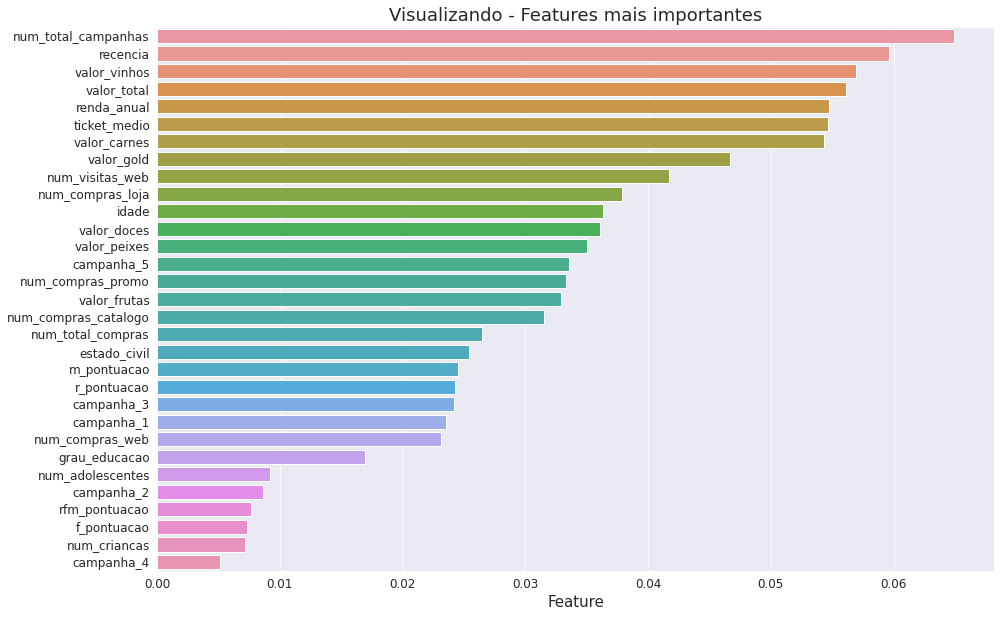

In [332]:
plt.figure(figsize=(15,10))

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Visualizando - Features mais importantes', fontsize=18)
plt.xlabel('Grau de importância', fontsize=15)
plt.xlabel('Feature', fontsize=15)

plt.xticks(size=12)
plt.yticks(size=12)

plt.show()

## Validação

In [333]:
print(classification_report(y_test, classificacao))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       567
           1       0.72      0.37      0.49        91

    accuracy                           0.89       658
   macro avg       0.82      0.68      0.72       658
weighted avg       0.88      0.89      0.88       658



In [334]:
print(pd.crosstab(y_test, classificacao, rownames=['Real'], colnames=['Classificado'], margins=True))

Classificado    0   1  All
Real                      
0             554  13  567
1              57  34   91
All           611  47  658


### Performance do Modelo
- Precision: 0.72<br>
- Acurária: 0.89

Porém, recall e f1-score estão muito ruins

# Modelo - Classificação (Balanceado)

In [347]:
# Separando o X e y (variável alvo)
X = df8.drop(columns=['id','resposta'])
y = df8.resposta

In [348]:
# Criando instância e tornando a classe 1, com 70% do tamanho da classe 0
smt = SMOTE(sampling_strategy=0.7)

In [349]:
# Aplicando o SMOTE, duplicando amostras da classe minoritária
X, y = smt.fit_resample(X,y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


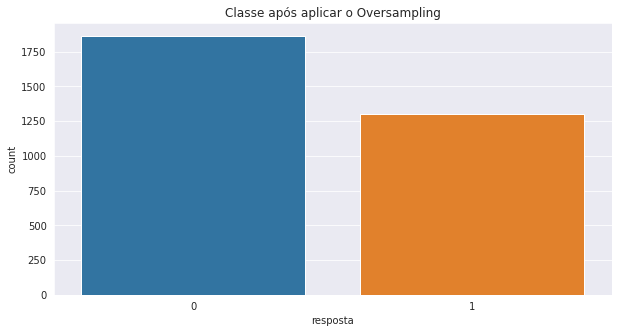

In [350]:
plt.figure(figsize=(10,5))

sns.countplot(y)
plt.title('Classe após aplicar o Oversampling')

plt.show()

In [351]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=22)

In [352]:
# instanciando o objeto
clf = RandomForestClassifier(random_state=22)

In [353]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=22)

In [354]:
classificacao = clf.predict(X_test)

In [355]:
pd.Series(classificacao).value_counts()

0    565
1    386
dtype: int64

In [356]:
print(classification_report(y_test, classificacao))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       579
           1       0.89      0.92      0.91       372

    accuracy                           0.92       951
   macro avg       0.92      0.92      0.92       951
weighted avg       0.93      0.92      0.92       951



In [357]:
print(pd.crosstab(y_test, classificacao, rownames=['Real'], colnames=['Classificado'], margins=True))

Classificado    0    1  All
Real                       
0             536   43  579
1              29  343  372
All           565  386  951


### Performance do Modelo
- Precision: 0.89<br>
- Acurária: 0.92

E recall e f1-score melhoraram também

### Precision
- dos casos que eu previ como positivos (para uma classe) quantos realmente são?
- orçamento *interessa*

### Recall
- dos que eram realmente positivos (para uma classe) quantos eu detectei?
- taxa de detecção
- orçamento não pesa

### F1 Score
- média harmônica entre os dois acima